In [1]:
import dpkt
import matplotlib.pyplot as plt
import matplotlib
import numpy
from scipy.spatial import distance as dist
import math
import pickle5 as pickle
import numpy as np
from scipy import spatial
from scipy import stats
import os
from datetime import datetime
import json
import csv

In [5]:
TransitionPeriod = 0.5

BarLength = 10
RTT = np.arange(0, 5, 0.5)
number_of_slots = 50
slot_length = float(2*BarLength) / number_of_slots
LENGTH = 0
minutes = [180]
minutes2 = [900, 1800]

size_threshold = 400000
time_threshold = 0.5
# LENGTH = 14400
first_second = 0
first_minute = 0
first_hour = 0
threshold = 0.3
amazon_ips = {}

# minutes = [180, 300, 900, 1800]
# LENGTH = 3600

In [3]:
#new from alireza
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
# matplotlib.rcParams['text.usetex'] = True
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)

import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

# Load the Data

In [4]:
data_dir = 'path/to/generated_messages/messages_pareto_xm_5000_alpha_0.93_max30delay_ver02'
userBurstArray = pickle.load(open(os.path.join(data_dir, 'all_user_bursts.pickle'), 'rb'))
advBurstArray = pickle.load(open(os.path.join(data_dir, 'all_channel_bursts.pickle'), 'rb'))

# Normalizing Traffic and Correlation Functions

In [6]:
def find_intervals(period_points, minute):
    num_of_intervals = int(3600 / minute)
    intervals = []
    for i in range(num_of_intervals):
        intervals.append([])
        startpoint = i * minute
        endpoint = (i+1) * minute
        for j in range(len(period_points)):
            if startpoint <= period_points[j][0] and period_points[j][0] < endpoint:
#                 intervals[-1].append(period_points[j])
                intervals[-1].append((period_points[j][0]-i*minute, period_points[j][1]))
                
    return intervals

def Stat_Correlation(hist1, hist2):
    l = min(len(hist1), len(hist2))
    data1 = hist1[0:l]
    data2 = hist2[0:l]
    if sum(data1) == 0 and sum(data2) == 0:
        return -1
    elif sum(data1) == 0 or sum(data2) == 0:
        return 0 
    else:
        num = 0
        p1 = 0
        p2 = 0
        for i in range(l):
            num = num + float(data1[i])*float(data2[i])
            p1 = p1 + float(math.pow(data1[i],2))
            p2 = p2 + float(math.pow(data2[i],2))
        return 2*num / (p1+p2)
    
def spread_volume(ChannelPeriodPoints, UserPeriodPoints, RTT):
	global BarLength
	global number_of_slots
	global slot_length
	Channel_spreaded = []
	User_spreaded = []
	for i in range(len(ChannelPeriodPoints)):
		start_time = ChannelPeriodPoints[i][0] - BarLength - RTT
		volume = ChannelPeriodPoints[i][1] / number_of_slots
		for slot_iter in range(number_of_slots):
			Channel_spreaded.append((start_time+slot_iter*slot_length, volume))
	for i in range(len(UserPeriodPoints)):
		start_time = UserPeriodPoints[i][0] - BarLength 
		volume = UserPeriodPoints[i][1] / number_of_slots
		for slot_iter in range(number_of_slots):
			User_spreaded.append((start_time+slot_iter*slot_length, volume))
	return (Channel_spreaded, User_spreaded)



def zero_pad(ChannelPeriodPoints, UserPeriodPoints, Channel_spreaded, User_spreaded, end_time, RTT):
	global BarLength
	global slot_length
	if len(ChannelPeriodPoints) == 0:
		slot = 0
		while(True):
			slot = slot + slot_length
			if slot >= end_time:
				break
			Channel_spreaded.append((slot, 0))

	elif len(UserPeriodPoints) == 0:
		slot = 0
		while(True):
			slot = slot + slot_length
			if slot >= end_time:
				break
			User_spreaded.append((slot, 0))
	else:		
		for i in range(len(ChannelPeriodPoints)+1):
			if i == 0:
				slot = 0
				endpoint = ChannelPeriodPoints[i][0] - BarLength - RTT
			elif i == len(ChannelPeriodPoints):
				slot = ChannelPeriodPoints[i-1][0] + BarLength
				endpoint = end_time
			else:
				slot = ChannelPeriodPoints[i-1][0] + BarLength - RTT
				endpoint = ChannelPeriodPoints[i][0] - BarLength - RTT
			while(True):
				slot = slot + slot_length
				if slot >= endpoint:
					break
				Channel_spreaded.append((slot, 0))

		for i in range(len(UserPeriodPoints)+1):
			if i == 0:
				slot = 0
				endpoint = UserPeriodPoints[i][0] - BarLength
			elif i == len(UserPeriodPoints):
				slot = UserPeriodPoints[i-1][0] + BarLength
				endpoint = end_time
			else:
				slot = UserPeriodPoints[i-1][0] + BarLength
				endpoint = UserPeriodPoints[i][0] - BarLength
			while(True):
				slot = slot + slot_length
				if slot >= endpoint:
					break
				User_spreaded.append((slot, 0))
			
def make_size_equal(Channel_spreaded_sorted,User_spreaded_sorted):
	global slot_length
	last_time_channel = Channel_spreaded_sorted[-1][0]
	last_time_user = User_spreaded_sorted[-1][0]
	if last_time_channel > last_time_user:
		slot = last_time_user
		while(True):
			slot = slot + slot_length
			if slot > last_time_channel:
				break
			User_spreaded_sorted.append((slot, 0))

	elif last_time_channel < last_time_user:
		slot = last_time_channel
		while(True):
			slot = slot + slot_length
			if slot > last_time_user:
				break
			Channel_spreaded_sorted.append((slot, 0))			


def DivideTime(time, data, minute):
	data_interval = []
	interval = minute
	num_of_intervals = int(time[-1] / interval)+1
	interval_counter = 1
	temp_time = []
	temp_data = []
	endpoint = interval_counter*interval
	for i in range(len(time)):
		if time[i] > endpoint:
			data_interval.append((temp_time, temp_data))
			temp_time = []
			temp_data = []
			temp_time.append(time[i])
			temp_data.append(data[i])
			interval_counter = interval_counter + 1
			endpoint = interval_counter*interval
		else:
			temp_time.append(time[i])
			temp_data.append(data[i])
			continue
		if interval_counter == num_of_intervals:
			# data_interval.append((time[i:], data[i:]))
			break
	return data_interval

def calculate_correlation(Channel_time, Channel_volume, User_time, User_volume):
	global minutes
	# RTT = np.arange(0, 20, 0.5)
	correlation = []
	for minute_iter in range(len(minutes)):
		Channel_intervals = DivideTime(Channel_time, Channel_volume, minutes[minute_iter])
		User_intervals = DivideTime(User_time, User_volume, minutes[minute_iter])
		# for rtt_iter in range(len(RTT)):
		length = min(len(Channel_intervals), len(User_intervals))
		correlation_per_interval = []
		for i in range(length):
			c = Stat_Correlation(User_intervals[i][1], Channel_intervals[i][1])
			correlation_per_interval.append(c)
		correlation.append(correlation_per_interval)
	return correlation

def normalize_traffic(ChannelPeriodPoints, UserPeriodPoints, rtt):
	# global RTT
	correlation = []
	temp_correlation = []
	end_time = ChannelPeriodPoints[-1][0] + 10
	(Channel_spreaded, User_spreaded) = spread_volume(ChannelPeriodPoints, UserPeriodPoints, rtt)
	zero_pad(ChannelPeriodPoints, UserPeriodPoints, Channel_spreaded, User_spreaded, end_time, rtt)
	Channel_spreaded_sorted = sorted(Channel_spreaded, key=lambda tup: tup[0])
	User_spreaded_sorted = sorted(User_spreaded, key=lambda tup: tup[0])
	make_size_equal(Channel_spreaded_sorted, User_spreaded_sorted)
	Channel_time = [x[0] for x in Channel_spreaded_sorted]
	Channel_volume = [x[1] for x in Channel_spreaded_sorted]
	User_time = [x[0] for x in User_spreaded_sorted]
	User_volume = [x[1] for x in User_spreaded_sorted]
	return (Channel_time, Channel_volume, User_time, User_volume)

def channel_correlation(ChannelPeriodPoints, UserPeriodPoints):
	global RTT
	correlation = []
	if len(ChannelPeriodPoints) == 0 and len(UserPeriodPoints) == 0:
		return []
	for i in range(len(RTT)):
		(Channel_time, Channel_volume, User_time, User_volume) = normalize_traffic(ChannelPeriodPoints, UserPeriodPoints, RTT[i])
		correlation_per_interval = calculate_correlation(Channel_time, Channel_volume, User_time, User_volume)
		correlation.append(correlation_per_interval)

	final_correlation = []

	for minute_iter in range(len(minutes)):
		correlation_per_minute = []
		for rtt_iter in range(len(RTT)):
			correlation_per_minute.append(correlation[rtt_iter][minute_iter])
		max_correlation_per_minute = []
		lengths = []
		for i in range(len(correlation_per_minute)):
			lengths.append(len(correlation_per_minute[i]))
		length = min(lengths)
		for i in range(length):
			temp_correlation = []
			for j in range(len(correlation_per_minute)):
				temp_correlation.append(correlation_per_minute[j][i])
			# if sum(temp_correlation) < -1*len(temp_correlation) / 2:
			# if sum(temp_correlation) < 0:
			# 	continue
			max_correlation_per_minute.append(max(temp_correlation))
		final_correlation.append(max_correlation_per_minute)		

	# final_final_correlation = []
	# for i in range(len(final_correlation)):
	# 	temp = []
	# 	for j in range(len(final_correlation[i])):
	# 		if final_correlation[i][j] != -1:
	# 			temp.append(final_correlation[i][j])
	# 	final_final_correlation.append(temp)
	return final_correlation


def organize_correlation(c):
	c_new = []
	for i in range(len(c)):
		temp = []
		for j in range(len(c[i])):
			if c[i][j] != -1:
				temp.append(c[i][j])
		c_new.append(temp)
	sample_length = 180
	c_3min = c[-1]
	for i in range(len(minutes2)):
		correlation_per_minute2 = []
		num_of_samples = int(minutes2[i] / sample_length)
		chunks = [c_3min[x:x+num_of_samples] for x in range(0, len(c_3min), num_of_samples)]
		# print chunks
		for j in range(len(chunks)):
			total_samples = 0
			sum_of_samples = 0				
			for k in range(len(chunks[j])):
				if chunks[j][k] != -1:
					total_samples += 1
					sum_of_samples += chunks[j][k]
			if sum_of_samples == 0 and total_samples == 0:
				continue
			correlation_per_minute2.append(sum_of_samples / float(total_samples))
		c_new.append(correlation_per_minute2)			
	return c_new	

# Functions to Calculate FPR and TPR

In [7]:
def cal_rates(corrs, th):
#     th = np.arange(0,1,0.01)
    rates = []
    for t in th:
        rate = np.sum(corrs >= t) / float(len(corrs))
        rates.append(rate)
        
    return rates

def cal_tp_fp(corrs, th):
#     th = np.arange(0,1,0.01)
    fp = []
    tp = []
    diag = np.diagonal(corrs)
    for t in th:
        tp_temp = np.sum(diag[diag >= t]) / float(len(diag))
        tp.append(tp_temp)
        fp_temp =0
        for i in range(corrs.shape[0]):
            for j in range(corrs.shape[0]):
                if i == j:
                    continue
                else:
                    if corrs[i,j] >= t:
                        fp_temp += 1
        fp.append(float(fp_temp) / (corrs.shape[0]*corrs.shape[1] - len(corrs)))
        
    return (tp,fp)

# Calculating Correlations

## Positive Samples (Correlated Pair of Flows)

In [8]:
corrTP = []
for i in range(len(minutes) + len(minutes2)):
    corrTP.append([])

for i in range(len(userBurstArray)):
    c = channel_correlation(advBurstArray[i], userBurstArray[i])
    if len(c) == 0:
        continue
    c_new = organize_correlation(c)
    for j in range(len(c_new)):
        corrTP[j].extend(c_new[j])

## Negative Samples (Uncorrelated Pair of Flows)

In [9]:
corrFP = []
for i in range(len(minutes) + len(minutes2)):
    corrFP.append([])
    
for i in range(len(userBurstArray)):
    for j in range(len(advBurstArray)):
        if i == j:
            continue
        c = channel_correlation(advBurstArray[i], userBurstArray[j])
        if len(c) == 0:
            continue
        c_new = organize_correlation(c)
        for k in range(len(c_new)):
            corrFP[k].extend(c_new[k])
        print (str(i) + " done with "+str(j))

0 done with 1
0 done with 2
0 done with 3
0 done with 4
0 done with 5
0 done with 6
0 done with 7
0 done with 8
0 done with 9
0 done with 10
0 done with 11
0 done with 12
0 done with 13
0 done with 14
0 done with 15
0 done with 16
0 done with 17
0 done with 18
0 done with 19
0 done with 20
0 done with 21
0 done with 22
0 done with 23
0 done with 24
0 done with 25
0 done with 26
0 done with 27
0 done with 28
0 done with 29
0 done with 30
0 done with 31
0 done with 32
0 done with 33
0 done with 34
0 done with 35
0 done with 36
0 done with 37
0 done with 38
0 done with 39
0 done with 40
0 done with 41
0 done with 42
0 done with 43
0 done with 44
0 done with 45
0 done with 46
0 done with 47
0 done with 48
0 done with 49
0 done with 50
0 done with 51
0 done with 52
0 done with 53
0 done with 54
0 done with 55
0 done with 56
0 done with 57
0 done with 58
0 done with 59
0 done with 60
0 done with 61
0 done with 62
0 done with 63
0 done with 64
0 done with 65
0 done with 66
0 done with 67
0 do

1 done with 260
1 done with 261
1 done with 262
1 done with 263
1 done with 264
1 done with 265
1 done with 266
1 done with 267
2 done with 0
2 done with 1
2 done with 3
2 done with 4
2 done with 5
2 done with 6
2 done with 7
2 done with 8
2 done with 9
2 done with 10
2 done with 11
2 done with 12
2 done with 13
2 done with 14
2 done with 15
2 done with 16
2 done with 17
2 done with 18
2 done with 19
2 done with 20
2 done with 21
2 done with 22
2 done with 23
2 done with 24
2 done with 25
2 done with 26
2 done with 27
2 done with 28
2 done with 29
2 done with 30
2 done with 31
2 done with 32
2 done with 33
2 done with 34
2 done with 35
2 done with 36
2 done with 37
2 done with 38
2 done with 39
2 done with 40
2 done with 41
2 done with 42
2 done with 43
2 done with 44
2 done with 45
2 done with 46
2 done with 47
2 done with 48
2 done with 49
2 done with 50
2 done with 51
2 done with 52
2 done with 53
2 done with 54
2 done with 55
2 done with 56
2 done with 57
2 done with 58
2 done with

3 done with 252
3 done with 253
3 done with 254
3 done with 255
3 done with 256
3 done with 257
3 done with 258
3 done with 259
3 done with 260
3 done with 261
3 done with 262
3 done with 263
3 done with 264
3 done with 265
3 done with 266
3 done with 267
4 done with 0
4 done with 1
4 done with 2
4 done with 3
4 done with 5
4 done with 6
4 done with 7
4 done with 8
4 done with 9
4 done with 10
4 done with 11
4 done with 12
4 done with 13
4 done with 14
4 done with 15
4 done with 16
4 done with 17
4 done with 18
4 done with 19
4 done with 20
4 done with 21
4 done with 22
4 done with 23
4 done with 24
4 done with 25
4 done with 26
4 done with 27
4 done with 28
4 done with 29
4 done with 30
4 done with 31
4 done with 32
4 done with 33
4 done with 34
4 done with 35
4 done with 36
4 done with 37
4 done with 38
4 done with 39
4 done with 40
4 done with 41
4 done with 42
4 done with 43
4 done with 44
4 done with 45
4 done with 46
4 done with 47
4 done with 48
4 done with 49
4 done with 50
4 d

5 done with 245
5 done with 246
5 done with 247
5 done with 248
5 done with 249
5 done with 250
5 done with 251
5 done with 252
5 done with 253
5 done with 254
5 done with 255
5 done with 256
5 done with 257
5 done with 258
5 done with 259
5 done with 260
5 done with 261
5 done with 262
5 done with 263
5 done with 264
5 done with 265
5 done with 266
5 done with 267
6 done with 0
6 done with 1
6 done with 2
6 done with 3
6 done with 4
6 done with 5
6 done with 7
6 done with 8
6 done with 9
6 done with 10
6 done with 11
6 done with 12
6 done with 13
6 done with 14
6 done with 15
6 done with 16
6 done with 17
6 done with 18
6 done with 19
6 done with 20
6 done with 21
6 done with 22
6 done with 23
6 done with 24
6 done with 25
6 done with 26
6 done with 27
6 done with 28
6 done with 29
6 done with 30
6 done with 31
6 done with 32
6 done with 33
6 done with 34
6 done with 35
6 done with 36
6 done with 37
6 done with 38
6 done with 39
6 done with 40
6 done with 41
6 done with 42
6 done with

7 done with 237
7 done with 238
7 done with 239
7 done with 240
7 done with 241
7 done with 242
7 done with 243
7 done with 244
7 done with 245
7 done with 246
7 done with 247
7 done with 248
7 done with 249
7 done with 250
7 done with 251
7 done with 252
7 done with 253
7 done with 254
7 done with 255
7 done with 256
7 done with 257
7 done with 258
7 done with 259
7 done with 260
7 done with 261
7 done with 262
7 done with 263
7 done with 264
7 done with 265
7 done with 266
7 done with 267
8 done with 0
8 done with 1
8 done with 2
8 done with 3
8 done with 4
8 done with 5
8 done with 6
8 done with 7
8 done with 9
8 done with 10
8 done with 11
8 done with 12
8 done with 13
8 done with 14
8 done with 15
8 done with 16
8 done with 17
8 done with 18
8 done with 19
8 done with 20
8 done with 21
8 done with 22
8 done with 23
8 done with 24
8 done with 25
8 done with 26
8 done with 27
8 done with 28
8 done with 29
8 done with 30
8 done with 31
8 done with 32
8 done with 33
8 done with 34
8 d

9 done with 229
9 done with 230
9 done with 231
9 done with 232
9 done with 233
9 done with 234
9 done with 235
9 done with 236
9 done with 237
9 done with 238
9 done with 239
9 done with 240
9 done with 241
9 done with 242
9 done with 243
9 done with 244
9 done with 245
9 done with 246
9 done with 247
9 done with 248
9 done with 249
9 done with 250
9 done with 251
9 done with 252
9 done with 253
9 done with 254
9 done with 255
9 done with 256
9 done with 257
9 done with 258
9 done with 259
9 done with 260
9 done with 261
9 done with 262
9 done with 263
9 done with 264
9 done with 265
9 done with 266
9 done with 267
10 done with 0
10 done with 1
10 done with 2
10 done with 3
10 done with 4
10 done with 5
10 done with 6
10 done with 7
10 done with 8
10 done with 9
10 done with 11
10 done with 12
10 done with 13
10 done with 14
10 done with 15
10 done with 16
10 done with 17
10 done with 18
10 done with 19
10 done with 20
10 done with 21
10 done with 22
10 done with 23
10 done with 24
10

11 done with 193
11 done with 194
11 done with 195
11 done with 196
11 done with 197
11 done with 198
11 done with 199
11 done with 200
11 done with 201
11 done with 202
11 done with 203
11 done with 204
11 done with 205
11 done with 206
11 done with 207
11 done with 208
11 done with 209
11 done with 210
11 done with 211
11 done with 212
11 done with 213
11 done with 214
11 done with 215
11 done with 216
11 done with 217
11 done with 218
11 done with 219
11 done with 220
11 done with 221
11 done with 222
11 done with 223
11 done with 224
11 done with 225
11 done with 226
11 done with 227
11 done with 228
11 done with 229
11 done with 230
11 done with 231
11 done with 232
11 done with 233
11 done with 234
11 done with 235
11 done with 236
11 done with 237
11 done with 238
11 done with 239
11 done with 240
11 done with 241
11 done with 242
11 done with 243
11 done with 244
11 done with 245
11 done with 246
11 done with 247
11 done with 248
11 done with 249
11 done with 250
11 done with 2

13 done with 155
13 done with 156
13 done with 157
13 done with 158
13 done with 159
13 done with 160
13 done with 161
13 done with 162
13 done with 163
13 done with 164
13 done with 165
13 done with 166
13 done with 167
13 done with 168
13 done with 169
13 done with 170
13 done with 171
13 done with 172
13 done with 173
13 done with 174
13 done with 175
13 done with 176
13 done with 177
13 done with 178
13 done with 179
13 done with 180
13 done with 181
13 done with 182
13 done with 183
13 done with 184
13 done with 185
13 done with 186
13 done with 187
13 done with 188
13 done with 189
13 done with 190
13 done with 191
13 done with 192
13 done with 193
13 done with 194
13 done with 195
13 done with 196
13 done with 197
13 done with 198
13 done with 199
13 done with 200
13 done with 201
13 done with 202
13 done with 203
13 done with 204
13 done with 205
13 done with 206
13 done with 207
13 done with 208
13 done with 209
13 done with 210
13 done with 211
13 done with 212
13 done with 2

15 done with 116
15 done with 117
15 done with 118
15 done with 119
15 done with 120
15 done with 121
15 done with 122
15 done with 123
15 done with 124
15 done with 125
15 done with 126
15 done with 127
15 done with 128
15 done with 129
15 done with 130
15 done with 131
15 done with 132
15 done with 133
15 done with 134
15 done with 135
15 done with 136
15 done with 137
15 done with 138
15 done with 139
15 done with 140
15 done with 141
15 done with 142
15 done with 143
15 done with 144
15 done with 145
15 done with 146
15 done with 147
15 done with 148
15 done with 149
15 done with 150
15 done with 151
15 done with 152
15 done with 153
15 done with 154
15 done with 155
15 done with 156
15 done with 157
15 done with 158
15 done with 159
15 done with 160
15 done with 161
15 done with 162
15 done with 163
15 done with 164
15 done with 165
15 done with 166
15 done with 167
15 done with 168
15 done with 169
15 done with 170
15 done with 171
15 done with 172
15 done with 173
15 done with 1

17 done with 77
17 done with 78
17 done with 79
17 done with 80
17 done with 81
17 done with 82
17 done with 83
17 done with 84
17 done with 85
17 done with 86
17 done with 87
17 done with 88
17 done with 89
17 done with 90
17 done with 91
17 done with 92
17 done with 93
17 done with 94
17 done with 95
17 done with 96
17 done with 97
17 done with 98
17 done with 99
17 done with 100
17 done with 101
17 done with 102
17 done with 103
17 done with 104
17 done with 105
17 done with 106
17 done with 107
17 done with 108
17 done with 109
17 done with 110
17 done with 111
17 done with 112
17 done with 113
17 done with 114
17 done with 115
17 done with 116
17 done with 117
17 done with 118
17 done with 119
17 done with 120
17 done with 121
17 done with 122
17 done with 123
17 done with 124
17 done with 125
17 done with 126
17 done with 127
17 done with 128
17 done with 129
17 done with 130
17 done with 131
17 done with 132
17 done with 133
17 done with 134
17 done with 135
17 done with 136
17 

19 done with 36
19 done with 37
19 done with 38
19 done with 39
19 done with 40
19 done with 41
19 done with 42
19 done with 43
19 done with 44
19 done with 45
19 done with 46
19 done with 47
19 done with 48
19 done with 49
19 done with 50
19 done with 51
19 done with 52
19 done with 53
19 done with 54
19 done with 55
19 done with 56
19 done with 57
19 done with 58
19 done with 59
19 done with 60
19 done with 61
19 done with 62
19 done with 63
19 done with 64
19 done with 65
19 done with 66
19 done with 67
19 done with 68
19 done with 69
19 done with 70
19 done with 71
19 done with 72
19 done with 73
19 done with 74
19 done with 75
19 done with 76
19 done with 77
19 done with 78
19 done with 79
19 done with 80
19 done with 81
19 done with 82
19 done with 83
19 done with 84
19 done with 85
19 done with 86
19 done with 87
19 done with 88
19 done with 89
19 done with 90
19 done with 91
19 done with 92
19 done with 93
19 done with 94
19 done with 95
19 done with 96
19 done with 97
19 done 

20 done with 262
20 done with 263
20 done with 264
20 done with 265
20 done with 266
20 done with 267
21 done with 0
21 done with 1
21 done with 2
21 done with 3
21 done with 4
21 done with 5
21 done with 6
21 done with 7
21 done with 8
21 done with 9
21 done with 10
21 done with 11
21 done with 12
21 done with 13
21 done with 14
21 done with 15
21 done with 16
21 done with 17
21 done with 18
21 done with 19
21 done with 20
21 done with 22
21 done with 23
21 done with 24
21 done with 25
21 done with 26
21 done with 27
21 done with 28
21 done with 29
21 done with 30
21 done with 31
21 done with 32
21 done with 33
21 done with 34
21 done with 35
21 done with 36
21 done with 37
21 done with 38
21 done with 39
21 done with 40
21 done with 41
21 done with 42
21 done with 43
21 done with 44
21 done with 45
21 done with 46
21 done with 47
21 done with 48
21 done with 49
21 done with 50
21 done with 51
21 done with 52
21 done with 53
21 done with 54
21 done with 55
21 done with 56
21 done with

22 done with 223
22 done with 224
22 done with 225
22 done with 226
22 done with 227
22 done with 228
22 done with 229
22 done with 230
22 done with 231
22 done with 232
22 done with 233
22 done with 234
22 done with 235
22 done with 236
22 done with 237
22 done with 238
22 done with 239
22 done with 240
22 done with 241
22 done with 242
22 done with 243
22 done with 244
22 done with 245
22 done with 246
22 done with 247
22 done with 248
22 done with 249
22 done with 250
22 done with 251
22 done with 252
22 done with 253
22 done with 254
22 done with 255
22 done with 256
22 done with 257
22 done with 258
22 done with 259
22 done with 260
22 done with 261
22 done with 262
22 done with 263
22 done with 264
22 done with 265
22 done with 266
22 done with 267
23 done with 0
23 done with 1
23 done with 2
23 done with 3
23 done with 4
23 done with 5
23 done with 6
23 done with 7
23 done with 8
23 done with 9
23 done with 10
23 done with 11
23 done with 12
23 done with 13
23 done with 14
23 do

24 done with 184
24 done with 185
24 done with 186
24 done with 187
24 done with 188
24 done with 189
24 done with 190
24 done with 191
24 done with 192
24 done with 193
24 done with 194
24 done with 195
24 done with 196
24 done with 197
24 done with 198
24 done with 199
24 done with 200
24 done with 201
24 done with 202
24 done with 203
24 done with 204
24 done with 205
24 done with 206
24 done with 207
24 done with 208
24 done with 209
24 done with 210
24 done with 211
24 done with 212
24 done with 213
24 done with 214
24 done with 215
24 done with 216
24 done with 217
24 done with 218
24 done with 219
24 done with 220
24 done with 221
24 done with 222
24 done with 223
24 done with 224
24 done with 225
24 done with 226
24 done with 227
24 done with 228
24 done with 229
24 done with 230
24 done with 231
24 done with 232
24 done with 233
24 done with 234
24 done with 235
24 done with 236
24 done with 237
24 done with 238
24 done with 239
24 done with 240
24 done with 241
24 done with 2

26 done with 145
26 done with 146
26 done with 147
26 done with 148
26 done with 149
26 done with 150
26 done with 151
26 done with 152
26 done with 153
26 done with 154
26 done with 155
26 done with 156
26 done with 157
26 done with 158
26 done with 159
26 done with 160
26 done with 161
26 done with 162
26 done with 163
26 done with 164
26 done with 165
26 done with 166
26 done with 167
26 done with 168
26 done with 169
26 done with 170
26 done with 171
26 done with 172
26 done with 173
26 done with 174
26 done with 175
26 done with 176
26 done with 177
26 done with 178
26 done with 179
26 done with 180
26 done with 181
26 done with 182
26 done with 183
26 done with 184
26 done with 185
26 done with 186
26 done with 187
26 done with 188
26 done with 189
26 done with 190
26 done with 191
26 done with 192
26 done with 193
26 done with 194
26 done with 195
26 done with 196
26 done with 197
26 done with 198
26 done with 199
26 done with 200
26 done with 201
26 done with 202
26 done with 2

28 done with 106
28 done with 107
28 done with 108
28 done with 109
28 done with 110
28 done with 111
28 done with 112
28 done with 113
28 done with 114
28 done with 115
28 done with 116
28 done with 117
28 done with 118
28 done with 119
28 done with 120
28 done with 121
28 done with 122
28 done with 123
28 done with 124
28 done with 125
28 done with 126
28 done with 127
28 done with 128
28 done with 129
28 done with 130
28 done with 131
28 done with 132
28 done with 133
28 done with 134
28 done with 135
28 done with 136
28 done with 137
28 done with 138
28 done with 139
28 done with 140
28 done with 141
28 done with 142
28 done with 143
28 done with 144
28 done with 145
28 done with 146
28 done with 147
28 done with 148
28 done with 149
28 done with 150
28 done with 151
28 done with 152
28 done with 153
28 done with 154
28 done with 155
28 done with 156
28 done with 157
28 done with 158
28 done with 159
28 done with 160
28 done with 161
28 done with 162
28 done with 163
28 done with 1

30 done with 65
30 done with 66
30 done with 67
30 done with 68
30 done with 69
30 done with 70
30 done with 71
30 done with 72
30 done with 73
30 done with 74
30 done with 75
30 done with 76
30 done with 77
30 done with 78
30 done with 79
30 done with 80
30 done with 81
30 done with 82
30 done with 83
30 done with 84
30 done with 85
30 done with 86
30 done with 87
30 done with 88
30 done with 89
30 done with 90
30 done with 91
30 done with 92
30 done with 93
30 done with 94
30 done with 95
30 done with 96
30 done with 97
30 done with 98
30 done with 99
30 done with 100
30 done with 101
30 done with 102
30 done with 103
30 done with 104
30 done with 105
30 done with 106
30 done with 107
30 done with 108
30 done with 109
30 done with 110
30 done with 111
30 done with 112
30 done with 113
30 done with 114
30 done with 115
30 done with 116
30 done with 117
30 done with 118
30 done with 119
30 done with 120
30 done with 121
30 done with 122
30 done with 123
30 done with 124
30 done with 12

32 done with 23
32 done with 24
32 done with 25
32 done with 26
32 done with 27
32 done with 28
32 done with 29
32 done with 30
32 done with 31
32 done with 33
32 done with 34
32 done with 35
32 done with 36
32 done with 37
32 done with 38
32 done with 39
32 done with 40
32 done with 41
32 done with 42
32 done with 43
32 done with 44
32 done with 45
32 done with 46
32 done with 47
32 done with 48
32 done with 49
32 done with 50
32 done with 51
32 done with 52
32 done with 53
32 done with 54
32 done with 55
32 done with 56
32 done with 57
32 done with 58
32 done with 59
32 done with 60
32 done with 61
32 done with 62
32 done with 63
32 done with 64
32 done with 65
32 done with 66
32 done with 67
32 done with 68
32 done with 69
32 done with 70
32 done with 71
32 done with 72
32 done with 73
32 done with 74
32 done with 75
32 done with 76
32 done with 77
32 done with 78
32 done with 79
32 done with 80
32 done with 81
32 done with 82
32 done with 83
32 done with 84
32 done with 85
32 done 

33 done with 250
33 done with 251
33 done with 252
33 done with 253
33 done with 254
33 done with 255
33 done with 256
33 done with 257
33 done with 258
33 done with 259
33 done with 260
33 done with 261
33 done with 262
33 done with 263
33 done with 264
33 done with 265
33 done with 266
33 done with 267
34 done with 0
34 done with 1
34 done with 2
34 done with 3
34 done with 4
34 done with 5
34 done with 6
34 done with 7
34 done with 8
34 done with 9
34 done with 10
34 done with 11
34 done with 12
34 done with 13
34 done with 14
34 done with 15
34 done with 16
34 done with 17
34 done with 18
34 done with 19
34 done with 20
34 done with 21
34 done with 22
34 done with 23
34 done with 24
34 done with 25
34 done with 26
34 done with 27
34 done with 28
34 done with 29
34 done with 30
34 done with 31
34 done with 32
34 done with 33
34 done with 35
34 done with 36
34 done with 37
34 done with 38
34 done with 39
34 done with 40
34 done with 41
34 done with 42
34 done with 43
34 done with 44


35 done with 211
35 done with 212
35 done with 213
35 done with 214
35 done with 215
35 done with 216
35 done with 217
35 done with 218
35 done with 219
35 done with 220
35 done with 221
35 done with 222
35 done with 223
35 done with 224
35 done with 225
35 done with 226
35 done with 227
35 done with 228
35 done with 229
35 done with 230
35 done with 231
35 done with 232
35 done with 233
35 done with 234
35 done with 235
35 done with 236
35 done with 237
35 done with 238
35 done with 239
35 done with 240
35 done with 241
35 done with 242
35 done with 243
35 done with 244
35 done with 245
35 done with 246
35 done with 247
35 done with 248
35 done with 249
35 done with 250
35 done with 251
35 done with 252
35 done with 253
35 done with 254
35 done with 255
35 done with 256
35 done with 257
35 done with 258
35 done with 259
35 done with 260
35 done with 261
35 done with 262
35 done with 263
35 done with 264
35 done with 265
35 done with 266
35 done with 267
36 done with 0
36 done with 1
3

37 done with 172
37 done with 173
37 done with 174
37 done with 175
37 done with 176
37 done with 177
37 done with 178
37 done with 179
37 done with 180
37 done with 181
37 done with 182
37 done with 183
37 done with 184
37 done with 185
37 done with 186
37 done with 187
37 done with 188
37 done with 189
37 done with 190
37 done with 191
37 done with 192
37 done with 193
37 done with 194
37 done with 195
37 done with 196
37 done with 197
37 done with 198
37 done with 199
37 done with 200
37 done with 201
37 done with 202
37 done with 203
37 done with 204
37 done with 205
37 done with 206
37 done with 207
37 done with 208
37 done with 209
37 done with 210
37 done with 211
37 done with 212
37 done with 213
37 done with 214
37 done with 215
37 done with 216
37 done with 217
37 done with 218
37 done with 219
37 done with 220
37 done with 221
37 done with 222
37 done with 223
37 done with 224
37 done with 225
37 done with 226
37 done with 227
37 done with 228
37 done with 229
37 done with 2

39 done with 133
39 done with 134
39 done with 135
39 done with 136
39 done with 137
39 done with 138
39 done with 139
39 done with 140
39 done with 141
39 done with 142
39 done with 143
39 done with 144
39 done with 145
39 done with 146
39 done with 147
39 done with 148
39 done with 149
39 done with 150
39 done with 151
39 done with 152
39 done with 153
39 done with 154
39 done with 155
39 done with 156
39 done with 157
39 done with 158
39 done with 159
39 done with 160
39 done with 161
39 done with 162
39 done with 163
39 done with 164
39 done with 165
39 done with 166
39 done with 167
39 done with 168
39 done with 169
39 done with 170
39 done with 171
39 done with 172
39 done with 173
39 done with 174
39 done with 175
39 done with 176
39 done with 177
39 done with 178
39 done with 179
39 done with 180
39 done with 181
39 done with 182
39 done with 183
39 done with 184
39 done with 185
39 done with 186
39 done with 187
39 done with 188
39 done with 189
39 done with 190
39 done with 1

41 done with 94
41 done with 95
41 done with 96
41 done with 97
41 done with 98
41 done with 99
41 done with 100
41 done with 101
41 done with 102
41 done with 103
41 done with 104
41 done with 105
41 done with 106
41 done with 107
41 done with 108
41 done with 109
41 done with 110
41 done with 111
41 done with 112
41 done with 113
41 done with 114
41 done with 115
41 done with 116
41 done with 117
41 done with 118
41 done with 119
41 done with 120
41 done with 121
41 done with 122
41 done with 123
41 done with 124
41 done with 125
41 done with 126
41 done with 127
41 done with 128
41 done with 129
41 done with 130
41 done with 131
41 done with 132
41 done with 133
41 done with 134
41 done with 135
41 done with 136
41 done with 137
41 done with 138
41 done with 139
41 done with 140
41 done with 141
41 done with 142
41 done with 143
41 done with 144
41 done with 145
41 done with 146
41 done with 147
41 done with 148
41 done with 149
41 done with 150
41 done with 151
41 done with 152
41 

43 done with 53
43 done with 54
43 done with 55
43 done with 56
43 done with 57
43 done with 58
43 done with 59
43 done with 60
43 done with 61
43 done with 62
43 done with 63
43 done with 64
43 done with 65
43 done with 66
43 done with 67
43 done with 68
43 done with 69
43 done with 70
43 done with 71
43 done with 72
43 done with 73
43 done with 74
43 done with 75
43 done with 76
43 done with 77
43 done with 78
43 done with 79
43 done with 80
43 done with 81
43 done with 82
43 done with 83
43 done with 84
43 done with 85
43 done with 86
43 done with 87
43 done with 88
43 done with 89
43 done with 90
43 done with 91
43 done with 92
43 done with 93
43 done with 94
43 done with 95
43 done with 96
43 done with 97
43 done with 98
43 done with 99
43 done with 100
43 done with 101
43 done with 102
43 done with 103
43 done with 104
43 done with 105
43 done with 106
43 done with 107
43 done with 108
43 done with 109
43 done with 110
43 done with 111
43 done with 112
43 done with 113
43 done wi

45 done with 11
45 done with 12
45 done with 13
45 done with 14
45 done with 15
45 done with 16
45 done with 17
45 done with 18
45 done with 19
45 done with 20
45 done with 21
45 done with 22
45 done with 23
45 done with 24
45 done with 25
45 done with 26
45 done with 27
45 done with 28
45 done with 29
45 done with 30
45 done with 31
45 done with 32
45 done with 33
45 done with 34
45 done with 35
45 done with 36
45 done with 37
45 done with 38
45 done with 39
45 done with 40
45 done with 41
45 done with 42
45 done with 43
45 done with 44
45 done with 46
45 done with 47
45 done with 48
45 done with 49
45 done with 50
45 done with 51
45 done with 52
45 done with 53
45 done with 54
45 done with 55
45 done with 56
45 done with 57
45 done with 58
45 done with 59
45 done with 60
45 done with 61
45 done with 62
45 done with 63
45 done with 64
45 done with 65
45 done with 66
45 done with 67
45 done with 68
45 done with 69
45 done with 70
45 done with 71
45 done with 72
45 done with 73
45 done 

46 done with 239
46 done with 240
46 done with 241
46 done with 242
46 done with 243
46 done with 244
46 done with 245
46 done with 246
46 done with 247
46 done with 248
46 done with 249
46 done with 250
46 done with 251
46 done with 252
46 done with 253
46 done with 254
46 done with 255
46 done with 256
46 done with 257
46 done with 258
46 done with 259
46 done with 260
46 done with 261
46 done with 262
46 done with 263
46 done with 264
46 done with 265
46 done with 266
46 done with 267
47 done with 0
47 done with 1
47 done with 2
47 done with 3
47 done with 4
47 done with 5
47 done with 6
47 done with 7
47 done with 8
47 done with 9
47 done with 10
47 done with 11
47 done with 12
47 done with 13
47 done with 14
47 done with 15
47 done with 16
47 done with 17
47 done with 18
47 done with 19
47 done with 20
47 done with 21
47 done with 22
47 done with 23
47 done with 24
47 done with 25
47 done with 26
47 done with 27
47 done with 28
47 done with 29
47 done with 30
47 done with 31
47 do

48 done with 200
48 done with 201
48 done with 202
48 done with 203
48 done with 204
48 done with 205
48 done with 206
48 done with 207
48 done with 208
48 done with 209
48 done with 210
48 done with 211
48 done with 212
48 done with 213
48 done with 214
48 done with 215
48 done with 216
48 done with 217
48 done with 218
48 done with 219
48 done with 220
48 done with 221
48 done with 222
48 done with 223
48 done with 224
48 done with 225
48 done with 226
48 done with 227
48 done with 228
48 done with 229
48 done with 230
48 done with 231
48 done with 232
48 done with 233
48 done with 234
48 done with 235
48 done with 236
48 done with 237
48 done with 238
48 done with 239
48 done with 240
48 done with 241
48 done with 242
48 done with 243
48 done with 244
48 done with 245
48 done with 246
48 done with 247
48 done with 248
48 done with 249
48 done with 250
48 done with 251
48 done with 252
48 done with 253
48 done with 254
48 done with 255
48 done with 256
48 done with 257
48 done with 2

50 done with 161
50 done with 162
50 done with 163
50 done with 164
50 done with 165
50 done with 166
50 done with 167
50 done with 168
50 done with 169
50 done with 170
50 done with 171
50 done with 172
50 done with 173
50 done with 174
50 done with 175
50 done with 176
50 done with 177
50 done with 178
50 done with 179
50 done with 180
50 done with 181
50 done with 182
50 done with 183
50 done with 184
50 done with 185
50 done with 186
50 done with 187
50 done with 188
50 done with 189
50 done with 190
50 done with 191
50 done with 192
50 done with 193
50 done with 194
50 done with 195
50 done with 196
50 done with 197
50 done with 198
50 done with 199
50 done with 200
50 done with 201
50 done with 202
50 done with 203
50 done with 204
50 done with 205
50 done with 206
50 done with 207
50 done with 208
50 done with 209
50 done with 210
50 done with 211
50 done with 212
50 done with 213
50 done with 214
50 done with 215
50 done with 216
50 done with 217
50 done with 218
50 done with 2

52 done with 122
52 done with 123
52 done with 124
52 done with 125
52 done with 126
52 done with 127
52 done with 128
52 done with 129
52 done with 130
52 done with 131
52 done with 132
52 done with 133
52 done with 134
52 done with 135
52 done with 136
52 done with 137
52 done with 138
52 done with 139
52 done with 140
52 done with 141
52 done with 142
52 done with 143
52 done with 144
52 done with 145
52 done with 146
52 done with 147
52 done with 148
52 done with 149
52 done with 150
52 done with 151
52 done with 152
52 done with 153
52 done with 154
52 done with 155
52 done with 156
52 done with 157
52 done with 158
52 done with 159
52 done with 160
52 done with 161
52 done with 162
52 done with 163
52 done with 164
52 done with 165
52 done with 166
52 done with 167
52 done with 168
52 done with 169
52 done with 170
52 done with 171
52 done with 172
52 done with 173
52 done with 174
52 done with 175
52 done with 176
52 done with 177
52 done with 178
52 done with 179
52 done with 1

54 done with 82
54 done with 83
54 done with 84
54 done with 85
54 done with 86
54 done with 87
54 done with 88
54 done with 89
54 done with 90
54 done with 91
54 done with 92
54 done with 93
54 done with 94
54 done with 95
54 done with 96
54 done with 97
54 done with 98
54 done with 99
54 done with 100
54 done with 101
54 done with 102
54 done with 103
54 done with 104
54 done with 105
54 done with 106
54 done with 107
54 done with 108
54 done with 109
54 done with 110
54 done with 111
54 done with 112
54 done with 113
54 done with 114
54 done with 115
54 done with 116
54 done with 117
54 done with 118
54 done with 119
54 done with 120
54 done with 121
54 done with 122
54 done with 123
54 done with 124
54 done with 125
54 done with 126
54 done with 127
54 done with 128
54 done with 129
54 done with 130
54 done with 131
54 done with 132
54 done with 133
54 done with 134
54 done with 135
54 done with 136
54 done with 137
54 done with 138
54 done with 139
54 done with 140
54 done with 14

56 done with 40
56 done with 41
56 done with 42
56 done with 43
56 done with 44
56 done with 45
56 done with 46
56 done with 47
56 done with 48
56 done with 49
56 done with 50
56 done with 51
56 done with 52
56 done with 53
56 done with 54
56 done with 55
56 done with 57
56 done with 58
56 done with 59
56 done with 60
56 done with 61
56 done with 62
56 done with 63
56 done with 64
56 done with 65
56 done with 66
56 done with 67
56 done with 68
56 done with 69
56 done with 70
56 done with 71
56 done with 72
56 done with 73
56 done with 74
56 done with 75
56 done with 76
56 done with 77
56 done with 78
56 done with 79
56 done with 80
56 done with 81
56 done with 82
56 done with 83
56 done with 84
56 done with 85
56 done with 86
56 done with 87
56 done with 88
56 done with 89
56 done with 90
56 done with 91
56 done with 92
56 done with 93
56 done with 94
56 done with 95
56 done with 96
56 done with 97
56 done with 98
56 done with 99
56 done with 100
56 done with 101
56 done with 102
56 do

57 done with 266
57 done with 267
58 done with 0
58 done with 1
58 done with 2
58 done with 3
58 done with 4
58 done with 5
58 done with 6
58 done with 7
58 done with 8
58 done with 9
58 done with 10
58 done with 11
58 done with 12
58 done with 13
58 done with 14
58 done with 15
58 done with 16
58 done with 17
58 done with 18
58 done with 19
58 done with 20
58 done with 21
58 done with 22
58 done with 23
58 done with 24
58 done with 25
58 done with 26
58 done with 27
58 done with 28
58 done with 29
58 done with 30
58 done with 31
58 done with 32
58 done with 33
58 done with 34
58 done with 35
58 done with 36
58 done with 37
58 done with 38
58 done with 39
58 done with 40
58 done with 41
58 done with 42
58 done with 43
58 done with 44
58 done with 45
58 done with 46
58 done with 47
58 done with 48
58 done with 49
58 done with 50
58 done with 51
58 done with 52
58 done with 53
58 done with 54
58 done with 55
58 done with 56
58 done with 57
58 done with 59
58 done with 60
58 done with 61


59 done with 227
59 done with 228
59 done with 229
59 done with 230
59 done with 231
59 done with 232
59 done with 233
59 done with 234
59 done with 235
59 done with 236
59 done with 237
59 done with 238
59 done with 239
59 done with 240
59 done with 241
59 done with 242
59 done with 243
59 done with 244
59 done with 245
59 done with 246
59 done with 247
59 done with 248
59 done with 249
59 done with 250
59 done with 251
59 done with 252
59 done with 253
59 done with 254
59 done with 255
59 done with 256
59 done with 257
59 done with 258
59 done with 259
59 done with 260
59 done with 261
59 done with 262
59 done with 263
59 done with 264
59 done with 265
59 done with 266
59 done with 267
60 done with 0
60 done with 1
60 done with 2
60 done with 3
60 done with 4
60 done with 5
60 done with 6
60 done with 7
60 done with 8
60 done with 9
60 done with 10
60 done with 11
60 done with 12
60 done with 13
60 done with 14
60 done with 15
60 done with 16
60 done with 17
60 done with 18
60 done w

61 done with 188
61 done with 189
61 done with 190
61 done with 191
61 done with 192
61 done with 193
61 done with 194
61 done with 195
61 done with 196
61 done with 197
61 done with 198
61 done with 199
61 done with 200
61 done with 201
61 done with 202
61 done with 203
61 done with 204
61 done with 205
61 done with 206
61 done with 207
61 done with 208
61 done with 209
61 done with 210
61 done with 211
61 done with 212
61 done with 213
61 done with 214
61 done with 215
61 done with 216
61 done with 217
61 done with 218
61 done with 219
61 done with 220
61 done with 221
61 done with 222
61 done with 223
61 done with 224
61 done with 225
61 done with 226
61 done with 227
61 done with 228
61 done with 229
61 done with 230
61 done with 231
61 done with 232
61 done with 233
61 done with 234
61 done with 235
61 done with 236
61 done with 237
61 done with 238
61 done with 239
61 done with 240
61 done with 241
61 done with 242
61 done with 243
61 done with 244
61 done with 245
61 done with 2

63 done with 150
63 done with 151
63 done with 152
63 done with 153
63 done with 154
63 done with 155
63 done with 156
63 done with 157
63 done with 158
63 done with 159
63 done with 160
63 done with 161
63 done with 162
63 done with 163
63 done with 164
63 done with 165
63 done with 166
63 done with 167
63 done with 168
63 done with 169
63 done with 170
63 done with 171
63 done with 172
63 done with 173
63 done with 174
63 done with 175
63 done with 176
63 done with 177
63 done with 178
63 done with 179
63 done with 180
63 done with 181
63 done with 182
63 done with 183
63 done with 184
63 done with 185
63 done with 186
63 done with 187
63 done with 188
63 done with 189
63 done with 190
63 done with 191
63 done with 192
63 done with 193
63 done with 194
63 done with 195
63 done with 196
63 done with 197
63 done with 198
63 done with 199
63 done with 200
63 done with 201
63 done with 202
63 done with 203
63 done with 204
63 done with 205
63 done with 206
63 done with 207
63 done with 2

65 done with 112
65 done with 113
65 done with 114
65 done with 115
65 done with 116
65 done with 117
65 done with 118
65 done with 119
65 done with 120
65 done with 121
65 done with 122
65 done with 123
65 done with 124
65 done with 125
65 done with 126
65 done with 127
65 done with 128
65 done with 129
65 done with 130
65 done with 131
65 done with 132
65 done with 133
65 done with 134
65 done with 135
65 done with 136
65 done with 137
65 done with 138
65 done with 139
65 done with 140
65 done with 141
65 done with 142
65 done with 143
65 done with 144
65 done with 145
65 done with 146
65 done with 147
65 done with 148
65 done with 149
65 done with 150
65 done with 151
65 done with 152
65 done with 153
65 done with 154
65 done with 155
65 done with 156
65 done with 157
65 done with 158
65 done with 159
65 done with 160
65 done with 161
65 done with 162
65 done with 163
65 done with 164
65 done with 165
65 done with 166
65 done with 167
65 done with 168
65 done with 169
65 done with 1

67 done with 72
67 done with 73
67 done with 74
67 done with 75
67 done with 76
67 done with 77
67 done with 78
67 done with 79
67 done with 80
67 done with 81
67 done with 82
67 done with 83
67 done with 84
67 done with 85
67 done with 86
67 done with 87
67 done with 88
67 done with 89
67 done with 90
67 done with 91
67 done with 92
67 done with 93
67 done with 94
67 done with 95
67 done with 96
67 done with 97
67 done with 98
67 done with 99
67 done with 100
67 done with 101
67 done with 102
67 done with 103
67 done with 104
67 done with 105
67 done with 106
67 done with 107
67 done with 108
67 done with 109
67 done with 110
67 done with 111
67 done with 112
67 done with 113
67 done with 114
67 done with 115
67 done with 116
67 done with 117
67 done with 118
67 done with 119
67 done with 120
67 done with 121
67 done with 122
67 done with 123
67 done with 124
67 done with 125
67 done with 126
67 done with 127
67 done with 128
67 done with 129
67 done with 130
67 done with 131
67 done 

69 done with 30
69 done with 31
69 done with 32
69 done with 33
69 done with 34
69 done with 35
69 done with 36
69 done with 37
69 done with 38
69 done with 39
69 done with 40
69 done with 41
69 done with 42
69 done with 43
69 done with 44
69 done with 45
69 done with 46
69 done with 47
69 done with 48
69 done with 49
69 done with 50
69 done with 51
69 done with 52
69 done with 53
69 done with 54
69 done with 55
69 done with 56
69 done with 57
69 done with 58
69 done with 59
69 done with 60
69 done with 61
69 done with 62
69 done with 63
69 done with 64
69 done with 65
69 done with 66
69 done with 67
69 done with 68
69 done with 70
69 done with 71
69 done with 72
69 done with 73
69 done with 74
69 done with 75
69 done with 76
69 done with 77
69 done with 78
69 done with 79
69 done with 80
69 done with 81
69 done with 82
69 done with 83
69 done with 84
69 done with 85
69 done with 86
69 done with 87
69 done with 88
69 done with 89
69 done with 90
69 done with 91
69 done with 92
69 done 

70 done with 257
70 done with 258
70 done with 259
70 done with 260
70 done with 261
70 done with 262
70 done with 263
70 done with 264
70 done with 265
70 done with 266
70 done with 267
71 done with 0
71 done with 1
71 done with 2
71 done with 3
71 done with 4
71 done with 5
71 done with 6
71 done with 7
71 done with 8
71 done with 9
71 done with 10
71 done with 11
71 done with 12
71 done with 13
71 done with 14
71 done with 15
71 done with 16
71 done with 17
71 done with 18
71 done with 19
71 done with 20
71 done with 21
71 done with 22
71 done with 23
71 done with 24
71 done with 25
71 done with 26
71 done with 27
71 done with 28
71 done with 29
71 done with 30
71 done with 31
71 done with 32
71 done with 33
71 done with 34
71 done with 35
71 done with 36
71 done with 37
71 done with 38
71 done with 39
71 done with 40
71 done with 41
71 done with 42
71 done with 43
71 done with 44
71 done with 45
71 done with 46
71 done with 47
71 done with 48
71 done with 49
71 done with 50
71 done

72 done with 219
72 done with 220
72 done with 221
72 done with 222
72 done with 223
72 done with 224
72 done with 225
72 done with 226
72 done with 227
72 done with 228
72 done with 229
72 done with 230
72 done with 231
72 done with 232
72 done with 233
72 done with 234
72 done with 235
72 done with 236
72 done with 237
72 done with 238
72 done with 239
72 done with 240
72 done with 241
72 done with 242
72 done with 243
72 done with 244
72 done with 245
72 done with 246
72 done with 247
72 done with 248
72 done with 249
72 done with 250
72 done with 251
72 done with 252
72 done with 253
72 done with 254
72 done with 255
72 done with 256
72 done with 257
72 done with 258
72 done with 259
72 done with 260
72 done with 261
72 done with 262
72 done with 263
72 done with 264
72 done with 265
72 done with 266
72 done with 267
73 done with 0
73 done with 1
73 done with 2
73 done with 3
73 done with 4
73 done with 5
73 done with 6
73 done with 7
73 done with 8
73 done with 9
73 done with 10
7

74 done with 181
74 done with 182
74 done with 183
74 done with 184
74 done with 185
74 done with 186
74 done with 187
74 done with 188
74 done with 189
74 done with 190
74 done with 191
74 done with 192
74 done with 193
74 done with 194
74 done with 195
74 done with 196
74 done with 197
74 done with 198
74 done with 199
74 done with 200
74 done with 201
74 done with 202
74 done with 203
74 done with 204
74 done with 205
74 done with 206
74 done with 207
74 done with 208
74 done with 209
74 done with 210
74 done with 211
74 done with 212
74 done with 213
74 done with 214
74 done with 215
74 done with 216
74 done with 217
74 done with 218
74 done with 219
74 done with 220
74 done with 221
74 done with 222
74 done with 223
74 done with 224
74 done with 225
74 done with 226
74 done with 227
74 done with 228
74 done with 229
74 done with 230
74 done with 231
74 done with 232
74 done with 233
74 done with 234
74 done with 235
74 done with 236
74 done with 237
74 done with 238
74 done with 2

76 done with 142
76 done with 143
76 done with 144
76 done with 145
76 done with 146
76 done with 147
76 done with 148
76 done with 149
76 done with 150
76 done with 151
76 done with 152
76 done with 153
76 done with 154
76 done with 155
76 done with 156
76 done with 157
76 done with 158
76 done with 159
76 done with 160
76 done with 161
76 done with 162
76 done with 163
76 done with 164
76 done with 165
76 done with 166
76 done with 167
76 done with 168
76 done with 169
76 done with 170
76 done with 171
76 done with 172
76 done with 173
76 done with 174
76 done with 175
76 done with 176
76 done with 177
76 done with 178
76 done with 179
76 done with 180
76 done with 181
76 done with 182
76 done with 183
76 done with 184
76 done with 185
76 done with 186
76 done with 187
76 done with 188
76 done with 189
76 done with 190
76 done with 191
76 done with 192
76 done with 193
76 done with 194
76 done with 195
76 done with 196
76 done with 197
76 done with 198
76 done with 199
76 done with 2

78 done with 103
78 done with 104
78 done with 105
78 done with 106
78 done with 107
78 done with 108
78 done with 109
78 done with 110
78 done with 111
78 done with 112
78 done with 113
78 done with 114
78 done with 115
78 done with 116
78 done with 117
78 done with 118
78 done with 119
78 done with 120
78 done with 121
78 done with 122
78 done with 123
78 done with 124
78 done with 125
78 done with 126
78 done with 127
78 done with 128
78 done with 129
78 done with 130
78 done with 131
78 done with 132
78 done with 133
78 done with 134
78 done with 135
78 done with 136
78 done with 137
78 done with 138
78 done with 139
78 done with 140
78 done with 141
78 done with 142
78 done with 143
78 done with 144
78 done with 145
78 done with 146
78 done with 147
78 done with 148
78 done with 149
78 done with 150
78 done with 151
78 done with 152
78 done with 153
78 done with 154
78 done with 155
78 done with 156
78 done with 157
78 done with 158
78 done with 159
78 done with 160
78 done with 1

80 done with 61
80 done with 62
80 done with 63
80 done with 64
80 done with 65
80 done with 66
80 done with 67
80 done with 68
80 done with 69
80 done with 70
80 done with 71
80 done with 72
80 done with 73
80 done with 74
80 done with 75
80 done with 76
80 done with 77
80 done with 78
80 done with 79
80 done with 81
80 done with 82
80 done with 83
80 done with 84
80 done with 85
80 done with 86
80 done with 87
80 done with 88
80 done with 89
80 done with 90
80 done with 91
80 done with 92
80 done with 93
80 done with 94
80 done with 95
80 done with 96
80 done with 97
80 done with 98
80 done with 99
80 done with 100
80 done with 101
80 done with 102
80 done with 103
80 done with 104
80 done with 105
80 done with 106
80 done with 107
80 done with 108
80 done with 109
80 done with 110
80 done with 111
80 done with 112
80 done with 113
80 done with 114
80 done with 115
80 done with 116
80 done with 117
80 done with 118
80 done with 119
80 done with 120
80 done with 121
80 done with 122
8

82 done with 20
82 done with 21
82 done with 22
82 done with 23
82 done with 24
82 done with 25
82 done with 26
82 done with 27
82 done with 28
82 done with 29
82 done with 30
82 done with 31
82 done with 32
82 done with 33
82 done with 34
82 done with 35
82 done with 36
82 done with 37
82 done with 38
82 done with 39
82 done with 40
82 done with 41
82 done with 42
82 done with 43
82 done with 44
82 done with 45
82 done with 46
82 done with 47
82 done with 48
82 done with 49
82 done with 50
82 done with 51
82 done with 52
82 done with 53
82 done with 54
82 done with 55
82 done with 56
82 done with 57
82 done with 58
82 done with 59
82 done with 60
82 done with 61
82 done with 62
82 done with 63
82 done with 64
82 done with 65
82 done with 66
82 done with 67
82 done with 68
82 done with 69
82 done with 70
82 done with 71
82 done with 72
82 done with 73
82 done with 74
82 done with 75
82 done with 76
82 done with 77
82 done with 78
82 done with 79
82 done with 80
82 done with 81
82 done 

83 done with 247
83 done with 248
83 done with 249
83 done with 250
83 done with 251
83 done with 252
83 done with 253
83 done with 254
83 done with 255
83 done with 256
83 done with 257
83 done with 258
83 done with 259
83 done with 260
83 done with 261
83 done with 262
83 done with 263
83 done with 264
83 done with 265
83 done with 266
83 done with 267
84 done with 0
84 done with 1
84 done with 2
84 done with 3
84 done with 4
84 done with 5
84 done with 6
84 done with 7
84 done with 8
84 done with 9
84 done with 10
84 done with 11
84 done with 12
84 done with 13
84 done with 14
84 done with 15
84 done with 16
84 done with 17
84 done with 18
84 done with 19
84 done with 20
84 done with 21
84 done with 22
84 done with 23
84 done with 24
84 done with 25
84 done with 26
84 done with 27
84 done with 28
84 done with 29
84 done with 30
84 done with 31
84 done with 32
84 done with 33
84 done with 34
84 done with 35
84 done with 36
84 done with 37
84 done with 38
84 done with 39
84 done with 

85 done with 209
85 done with 210
85 done with 211
85 done with 212
85 done with 213
85 done with 214
85 done with 215
85 done with 216
85 done with 217
85 done with 218
85 done with 219
85 done with 220
85 done with 221
85 done with 222
85 done with 223
85 done with 224
85 done with 225
85 done with 226
85 done with 227
85 done with 228
85 done with 229
85 done with 230
85 done with 231
85 done with 232
85 done with 233
85 done with 234
85 done with 235
85 done with 236
85 done with 237
85 done with 238
85 done with 239
85 done with 240
85 done with 241
85 done with 242
85 done with 243
85 done with 244
85 done with 245
85 done with 246
85 done with 247
85 done with 248
85 done with 249
85 done with 250
85 done with 251
85 done with 252
85 done with 253
85 done with 254
85 done with 255
85 done with 256
85 done with 257
85 done with 258
85 done with 259
85 done with 260
85 done with 261
85 done with 262
85 done with 263
85 done with 264
85 done with 265
85 done with 266
85 done with 2

87 done with 170
87 done with 171
87 done with 172
87 done with 173
87 done with 174
87 done with 175
87 done with 176
87 done with 177
87 done with 178
87 done with 179
87 done with 180
87 done with 181
87 done with 182
87 done with 183
87 done with 184
87 done with 185
87 done with 186
87 done with 187
87 done with 188
87 done with 189
87 done with 190
87 done with 191
87 done with 192
87 done with 193
87 done with 194
87 done with 195
87 done with 196
87 done with 197
87 done with 198
87 done with 199
87 done with 200
87 done with 201
87 done with 202
87 done with 203
87 done with 204
87 done with 205
87 done with 206
87 done with 207
87 done with 208
87 done with 209
87 done with 210
87 done with 211
87 done with 212
87 done with 213
87 done with 214
87 done with 215
87 done with 216
87 done with 217
87 done with 218
87 done with 219
87 done with 220
87 done with 221
87 done with 222
87 done with 223
87 done with 224
87 done with 225
87 done with 226
87 done with 227
87 done with 2

89 done with 131
89 done with 132
89 done with 133
89 done with 134
89 done with 135
89 done with 136
89 done with 137
89 done with 138
89 done with 139
89 done with 140
89 done with 141
89 done with 142
89 done with 143
89 done with 144
89 done with 145
89 done with 146
89 done with 147
89 done with 148
89 done with 149
89 done with 150
89 done with 151
89 done with 152
89 done with 153
89 done with 154
89 done with 155
89 done with 156
89 done with 157
89 done with 158
89 done with 159
89 done with 160
89 done with 161
89 done with 162
89 done with 163
89 done with 164
89 done with 165
89 done with 166
89 done with 167
89 done with 168
89 done with 169
89 done with 170
89 done with 171
89 done with 172
89 done with 173
89 done with 174
89 done with 175
89 done with 176
89 done with 177
89 done with 178
89 done with 179
89 done with 180
89 done with 181
89 done with 182
89 done with 183
89 done with 184
89 done with 185
89 done with 186
89 done with 187
89 done with 188
89 done with 1

91 done with 92
91 done with 93
91 done with 94
91 done with 95
91 done with 96
91 done with 97
91 done with 98
91 done with 99
91 done with 100
91 done with 101
91 done with 102
91 done with 103
91 done with 104
91 done with 105
91 done with 106
91 done with 107
91 done with 108
91 done with 109
91 done with 110
91 done with 111
91 done with 112
91 done with 113
91 done with 114
91 done with 115
91 done with 116
91 done with 117
91 done with 118
91 done with 119
91 done with 120
91 done with 121
91 done with 122
91 done with 123
91 done with 124
91 done with 125
91 done with 126
91 done with 127
91 done with 128
91 done with 129
91 done with 130
91 done with 131
91 done with 132
91 done with 133
91 done with 134
91 done with 135
91 done with 136
91 done with 137
91 done with 138
91 done with 139
91 done with 140
91 done with 141
91 done with 142
91 done with 143
91 done with 144
91 done with 145
91 done with 146
91 done with 147
91 done with 148
91 done with 149
91 done with 150
91 do

93 done with 50
93 done with 51
93 done with 52
93 done with 53
93 done with 54
93 done with 55
93 done with 56
93 done with 57
93 done with 58
93 done with 59
93 done with 60
93 done with 61
93 done with 62
93 done with 63
93 done with 64
93 done with 65
93 done with 66
93 done with 67
93 done with 68
93 done with 69
93 done with 70
93 done with 71
93 done with 72
93 done with 73
93 done with 74
93 done with 75
93 done with 76
93 done with 77
93 done with 78
93 done with 79
93 done with 80
93 done with 81
93 done with 82
93 done with 83
93 done with 84
93 done with 85
93 done with 86
93 done with 87
93 done with 88
93 done with 89
93 done with 90
93 done with 91
93 done with 92
93 done with 94
93 done with 95
93 done with 96
93 done with 97
93 done with 98
93 done with 99
93 done with 100
93 done with 101
93 done with 102
93 done with 103
93 done with 104
93 done with 105
93 done with 106
93 done with 107
93 done with 108
93 done with 109
93 done with 110
93 done with 111
93 done with

95 done with 10
95 done with 11
95 done with 12
95 done with 13
95 done with 14
95 done with 15
95 done with 16
95 done with 17
95 done with 18
95 done with 19
95 done with 20
95 done with 21
95 done with 22
95 done with 23
95 done with 24
95 done with 25
95 done with 26
95 done with 27
95 done with 28
95 done with 29
95 done with 30
95 done with 31
95 done with 32
95 done with 33
95 done with 34
95 done with 35
95 done with 36
95 done with 37
95 done with 38
95 done with 39
95 done with 40
95 done with 41
95 done with 42
95 done with 43
95 done with 44
95 done with 45
95 done with 46
95 done with 47
95 done with 48
95 done with 49
95 done with 50
95 done with 51
95 done with 52
95 done with 53
95 done with 54
95 done with 55
95 done with 56
95 done with 57
95 done with 58
95 done with 59
95 done with 60
95 done with 61
95 done with 62
95 done with 63
95 done with 64
95 done with 65
95 done with 66
95 done with 67
95 done with 68
95 done with 69
95 done with 70
95 done with 71
95 done 

96 done with 238
96 done with 239
96 done with 240
96 done with 241
96 done with 242
96 done with 243
96 done with 244
96 done with 245
96 done with 246
96 done with 247
96 done with 248
96 done with 249
96 done with 250
96 done with 251
96 done with 252
96 done with 253
96 done with 254
96 done with 255
96 done with 256
96 done with 257
96 done with 258
96 done with 259
96 done with 260
96 done with 261
96 done with 262
96 done with 263
96 done with 264
96 done with 265
96 done with 266
96 done with 267
97 done with 0
97 done with 1
97 done with 2
97 done with 3
97 done with 4
97 done with 5
97 done with 6
97 done with 7
97 done with 8
97 done with 9
97 done with 10
97 done with 11
97 done with 12
97 done with 13
97 done with 14
97 done with 15
97 done with 16
97 done with 17
97 done with 18
97 done with 19
97 done with 20
97 done with 21
97 done with 22
97 done with 23
97 done with 24
97 done with 25
97 done with 26
97 done with 27
97 done with 28
97 done with 29
97 done with 30
97 d

98 done with 199
98 done with 200
98 done with 201
98 done with 202
98 done with 203
98 done with 204
98 done with 205
98 done with 206
98 done with 207
98 done with 208
98 done with 209
98 done with 210
98 done with 211
98 done with 212
98 done with 213
98 done with 214
98 done with 215
98 done with 216
98 done with 217
98 done with 218
98 done with 219
98 done with 220
98 done with 221
98 done with 222
98 done with 223
98 done with 224
98 done with 225
98 done with 226
98 done with 227
98 done with 228
98 done with 229
98 done with 230
98 done with 231
98 done with 232
98 done with 233
98 done with 234
98 done with 235
98 done with 236
98 done with 237
98 done with 238
98 done with 239
98 done with 240
98 done with 241
98 done with 242
98 done with 243
98 done with 244
98 done with 245
98 done with 246
98 done with 247
98 done with 248
98 done with 249
98 done with 250
98 done with 251
98 done with 252
98 done with 253
98 done with 254
98 done with 255
98 done with 256
98 done with 2

100 done with 151
100 done with 152
100 done with 153
100 done with 154
100 done with 155
100 done with 156
100 done with 157
100 done with 158
100 done with 159
100 done with 160
100 done with 161
100 done with 162
100 done with 163
100 done with 164
100 done with 165
100 done with 166
100 done with 167
100 done with 168
100 done with 169
100 done with 170
100 done with 171
100 done with 172
100 done with 173
100 done with 174
100 done with 175
100 done with 176
100 done with 177
100 done with 178
100 done with 179
100 done with 180
100 done with 181
100 done with 182
100 done with 183
100 done with 184
100 done with 185
100 done with 186
100 done with 187
100 done with 188
100 done with 189
100 done with 190
100 done with 191
100 done with 192
100 done with 193
100 done with 194
100 done with 195
100 done with 196
100 done with 197
100 done with 198
100 done with 199
100 done with 200
100 done with 201
100 done with 202
100 done with 203
100 done with 204
100 done with 205
100 done w

102 done with 84
102 done with 85
102 done with 86
102 done with 87
102 done with 88
102 done with 89
102 done with 90
102 done with 91
102 done with 92
102 done with 93
102 done with 94
102 done with 95
102 done with 96
102 done with 97
102 done with 98
102 done with 99
102 done with 100
102 done with 101
102 done with 103
102 done with 104
102 done with 105
102 done with 106
102 done with 107
102 done with 108
102 done with 109
102 done with 110
102 done with 111
102 done with 112
102 done with 113
102 done with 114
102 done with 115
102 done with 116
102 done with 117
102 done with 118
102 done with 119
102 done with 120
102 done with 121
102 done with 122
102 done with 123
102 done with 124
102 done with 125
102 done with 126
102 done with 127
102 done with 128
102 done with 129
102 done with 130
102 done with 131
102 done with 132
102 done with 133
102 done with 134
102 done with 135
102 done with 136
102 done with 137
102 done with 138
102 done with 139
102 done with 140
102 done

104 done with 14
104 done with 15
104 done with 16
104 done with 17
104 done with 18
104 done with 19
104 done with 20
104 done with 21
104 done with 22
104 done with 23
104 done with 24
104 done with 25
104 done with 26
104 done with 27
104 done with 28
104 done with 29
104 done with 30
104 done with 31
104 done with 32
104 done with 33
104 done with 34
104 done with 35
104 done with 36
104 done with 37
104 done with 38
104 done with 39
104 done with 40
104 done with 41
104 done with 42
104 done with 43
104 done with 44
104 done with 45
104 done with 46
104 done with 47
104 done with 48
104 done with 49
104 done with 50
104 done with 51
104 done with 52
104 done with 53
104 done with 54
104 done with 55
104 done with 56
104 done with 57
104 done with 58
104 done with 59
104 done with 60
104 done with 61
104 done with 62
104 done with 63
104 done with 64
104 done with 65
104 done with 66
104 done with 67
104 done with 68
104 done with 69
104 done with 70
104 done with 71
104 done with 

105 done with 215
105 done with 216
105 done with 217
105 done with 218
105 done with 219
105 done with 220
105 done with 221
105 done with 222
105 done with 223
105 done with 224
105 done with 225
105 done with 226
105 done with 227
105 done with 228
105 done with 229
105 done with 230
105 done with 231
105 done with 232
105 done with 233
105 done with 234
105 done with 235
105 done with 236
105 done with 237
105 done with 238
105 done with 239
105 done with 240
105 done with 241
105 done with 242
105 done with 243
105 done with 244
105 done with 245
105 done with 246
105 done with 247
105 done with 248
105 done with 249
105 done with 250
105 done with 251
105 done with 252
105 done with 253
105 done with 254
105 done with 255
105 done with 256
105 done with 257
105 done with 258
105 done with 259
105 done with 260
105 done with 261
105 done with 262
105 done with 263
105 done with 264
105 done with 265
105 done with 266
105 done with 267
106 done with 0
106 done with 1
106 done with 

107 done with 150
107 done with 151
107 done with 152
107 done with 153
107 done with 154
107 done with 155
107 done with 156
107 done with 157
107 done with 158
107 done with 159
107 done with 160
107 done with 161
107 done with 162
107 done with 163
107 done with 164
107 done with 165
107 done with 166
107 done with 167
107 done with 168
107 done with 169
107 done with 170
107 done with 171
107 done with 172
107 done with 173
107 done with 174
107 done with 175
107 done with 176
107 done with 177
107 done with 178
107 done with 179
107 done with 180
107 done with 181
107 done with 182
107 done with 183
107 done with 184
107 done with 185
107 done with 186
107 done with 187
107 done with 188
107 done with 189
107 done with 190
107 done with 191
107 done with 192
107 done with 193
107 done with 194
107 done with 195
107 done with 196
107 done with 197
107 done with 198
107 done with 199
107 done with 200
107 done with 201
107 done with 202
107 done with 203
107 done with 204
107 done w

109 done with 82
109 done with 83
109 done with 84
109 done with 85
109 done with 86
109 done with 87
109 done with 88
109 done with 89
109 done with 90
109 done with 91
109 done with 92
109 done with 93
109 done with 94
109 done with 95
109 done with 96
109 done with 97
109 done with 98
109 done with 99
109 done with 100
109 done with 101
109 done with 102
109 done with 103
109 done with 104
109 done with 105
109 done with 106
109 done with 107
109 done with 108
109 done with 110
109 done with 111
109 done with 112
109 done with 113
109 done with 114
109 done with 115
109 done with 116
109 done with 117
109 done with 118
109 done with 119
109 done with 120
109 done with 121
109 done with 122
109 done with 123
109 done with 124
109 done with 125
109 done with 126
109 done with 127
109 done with 128
109 done with 129
109 done with 130
109 done with 131
109 done with 132
109 done with 133
109 done with 134
109 done with 135
109 done with 136
109 done with 137
109 done with 138
109 done w

111 done with 12
111 done with 13
111 done with 14
111 done with 15
111 done with 16
111 done with 17
111 done with 18
111 done with 19
111 done with 20
111 done with 21
111 done with 22
111 done with 23
111 done with 24
111 done with 25
111 done with 26
111 done with 27
111 done with 28
111 done with 29
111 done with 30
111 done with 31
111 done with 32
111 done with 33
111 done with 34
111 done with 35
111 done with 36
111 done with 37
111 done with 38
111 done with 39
111 done with 40
111 done with 41
111 done with 42
111 done with 43
111 done with 44
111 done with 45
111 done with 46
111 done with 47
111 done with 48
111 done with 49
111 done with 50
111 done with 51
111 done with 52
111 done with 53
111 done with 54
111 done with 55
111 done with 56
111 done with 57
111 done with 58
111 done with 59
111 done with 60
111 done with 61
111 done with 62
111 done with 63
111 done with 64
111 done with 65
111 done with 66
111 done with 67
111 done with 68
111 done with 69
111 done with 

112 done with 213
112 done with 214
112 done with 215
112 done with 216
112 done with 217
112 done with 218
112 done with 219
112 done with 220
112 done with 221
112 done with 222
112 done with 223
112 done with 224
112 done with 225
112 done with 226
112 done with 227
112 done with 228
112 done with 229
112 done with 230
112 done with 231
112 done with 232
112 done with 233
112 done with 234
112 done with 235
112 done with 236
112 done with 237
112 done with 238
112 done with 239
112 done with 240
112 done with 241
112 done with 242
112 done with 243
112 done with 244
112 done with 245
112 done with 246
112 done with 247
112 done with 248
112 done with 249
112 done with 250
112 done with 251
112 done with 252
112 done with 253
112 done with 254
112 done with 255
112 done with 256
112 done with 257
112 done with 258
112 done with 259
112 done with 260
112 done with 261
112 done with 262
112 done with 263
112 done with 264
112 done with 265
112 done with 266
112 done with 267
113 done w

114 done with 147
114 done with 148
114 done with 149
114 done with 150
114 done with 151
114 done with 152
114 done with 153
114 done with 154
114 done with 155
114 done with 156
114 done with 157
114 done with 158
114 done with 159
114 done with 160
114 done with 161
114 done with 162
114 done with 163
114 done with 164
114 done with 165
114 done with 166
114 done with 167
114 done with 168
114 done with 169
114 done with 170
114 done with 171
114 done with 172
114 done with 173
114 done with 174
114 done with 175
114 done with 176
114 done with 177
114 done with 178
114 done with 179
114 done with 180
114 done with 181
114 done with 182
114 done with 183
114 done with 184
114 done with 185
114 done with 186
114 done with 187
114 done with 188
114 done with 189
114 done with 190
114 done with 191
114 done with 192
114 done with 193
114 done with 194
114 done with 195
114 done with 196
114 done with 197
114 done with 198
114 done with 199
114 done with 200
114 done with 201
114 done w

116 done with 79
116 done with 80
116 done with 81
116 done with 82
116 done with 83
116 done with 84
116 done with 85
116 done with 86
116 done with 87
116 done with 88
116 done with 89
116 done with 90
116 done with 91
116 done with 92
116 done with 93
116 done with 94
116 done with 95
116 done with 96
116 done with 97
116 done with 98
116 done with 99
116 done with 100
116 done with 101
116 done with 102
116 done with 103
116 done with 104
116 done with 105
116 done with 106
116 done with 107
116 done with 108
116 done with 109
116 done with 110
116 done with 111
116 done with 112
116 done with 113
116 done with 114
116 done with 115
116 done with 117
116 done with 118
116 done with 119
116 done with 120
116 done with 121
116 done with 122
116 done with 123
116 done with 124
116 done with 125
116 done with 126
116 done with 127
116 done with 128
116 done with 129
116 done with 130
116 done with 131
116 done with 132
116 done with 133
116 done with 134
116 done with 135
116 done with

118 done with 9
118 done with 10
118 done with 11
118 done with 12
118 done with 13
118 done with 14
118 done with 15
118 done with 16
118 done with 17
118 done with 18
118 done with 19
118 done with 20
118 done with 21
118 done with 22
118 done with 23
118 done with 24
118 done with 25
118 done with 26
118 done with 27
118 done with 28
118 done with 29
118 done with 30
118 done with 31
118 done with 32
118 done with 33
118 done with 34
118 done with 35
118 done with 36
118 done with 37
118 done with 38
118 done with 39
118 done with 40
118 done with 41
118 done with 42
118 done with 43
118 done with 44
118 done with 45
118 done with 46
118 done with 47
118 done with 48
118 done with 49
118 done with 50
118 done with 51
118 done with 52
118 done with 53
118 done with 54
118 done with 55
118 done with 56
118 done with 57
118 done with 58
118 done with 59
118 done with 60
118 done with 61
118 done with 62
118 done with 63
118 done with 64
118 done with 65
118 done with 66
118 done with 6

119 done with 210
119 done with 211
119 done with 212
119 done with 213
119 done with 214
119 done with 215
119 done with 216
119 done with 217
119 done with 218
119 done with 219
119 done with 220
119 done with 221
119 done with 222
119 done with 223
119 done with 224
119 done with 225
119 done with 226
119 done with 227
119 done with 228
119 done with 229
119 done with 230
119 done with 231
119 done with 232
119 done with 233
119 done with 234
119 done with 235
119 done with 236
119 done with 237
119 done with 238
119 done with 239
119 done with 240
119 done with 241
119 done with 242
119 done with 243
119 done with 244
119 done with 245
119 done with 246
119 done with 247
119 done with 248
119 done with 249
119 done with 250
119 done with 251
119 done with 252
119 done with 253
119 done with 254
119 done with 255
119 done with 256
119 done with 257
119 done with 258
119 done with 259
119 done with 260
119 done with 261
119 done with 262
119 done with 263
119 done with 264
119 done w

121 done with 144
121 done with 145
121 done with 146
121 done with 147
121 done with 148
121 done with 149
121 done with 150
121 done with 151
121 done with 152
121 done with 153
121 done with 154
121 done with 155
121 done with 156
121 done with 157
121 done with 158
121 done with 159
121 done with 160
121 done with 161
121 done with 162
121 done with 163
121 done with 164
121 done with 165
121 done with 166
121 done with 167
121 done with 168
121 done with 169
121 done with 170
121 done with 171
121 done with 172
121 done with 173
121 done with 174
121 done with 175
121 done with 176
121 done with 177
121 done with 178
121 done with 179
121 done with 180
121 done with 181
121 done with 182
121 done with 183
121 done with 184
121 done with 185
121 done with 186
121 done with 187
121 done with 188
121 done with 189
121 done with 190
121 done with 191
121 done with 192
121 done with 193
121 done with 194
121 done with 195
121 done with 196
121 done with 197
121 done with 198
121 done w

123 done with 75
123 done with 76
123 done with 77
123 done with 78
123 done with 79
123 done with 80
123 done with 81
123 done with 82
123 done with 83
123 done with 84
123 done with 85
123 done with 86
123 done with 87
123 done with 88
123 done with 89
123 done with 90
123 done with 91
123 done with 92
123 done with 93
123 done with 94
123 done with 95
123 done with 96
123 done with 97
123 done with 98
123 done with 99
123 done with 100
123 done with 101
123 done with 102
123 done with 103
123 done with 104
123 done with 105
123 done with 106
123 done with 107
123 done with 108
123 done with 109
123 done with 110
123 done with 111
123 done with 112
123 done with 113
123 done with 114
123 done with 115
123 done with 116
123 done with 117
123 done with 118
123 done with 119
123 done with 120
123 done with 121
123 done with 122
123 done with 124
123 done with 125
123 done with 126
123 done with 127
123 done with 128
123 done with 129
123 done with 130
123 done with 131
123 done with 132

125 done with 5
125 done with 6
125 done with 7
125 done with 8
125 done with 9
125 done with 10
125 done with 11
125 done with 12
125 done with 13
125 done with 14
125 done with 15
125 done with 16
125 done with 17
125 done with 18
125 done with 19
125 done with 20
125 done with 21
125 done with 22
125 done with 23
125 done with 24
125 done with 25
125 done with 26
125 done with 27
125 done with 28
125 done with 29
125 done with 30
125 done with 31
125 done with 32
125 done with 33
125 done with 34
125 done with 35
125 done with 36
125 done with 37
125 done with 38
125 done with 39
125 done with 40
125 done with 41
125 done with 42
125 done with 43
125 done with 44
125 done with 45
125 done with 46
125 done with 47
125 done with 48
125 done with 49
125 done with 50
125 done with 51
125 done with 52
125 done with 53
125 done with 54
125 done with 55
125 done with 56
125 done with 57
125 done with 58
125 done with 59
125 done with 60
125 done with 61
125 done with 62
125 done with 63
12

126 done with 206
126 done with 207
126 done with 208
126 done with 209
126 done with 210
126 done with 211
126 done with 212
126 done with 213
126 done with 214
126 done with 215
126 done with 216
126 done with 217
126 done with 218
126 done with 219
126 done with 220
126 done with 221
126 done with 222
126 done with 223
126 done with 224
126 done with 225
126 done with 226
126 done with 227
126 done with 228
126 done with 229
126 done with 230
126 done with 231
126 done with 232
126 done with 233
126 done with 234
126 done with 235
126 done with 236
126 done with 237
126 done with 238
126 done with 239
126 done with 240
126 done with 241
126 done with 242
126 done with 243
126 done with 244
126 done with 245
126 done with 246
126 done with 247
126 done with 248
126 done with 249
126 done with 250
126 done with 251
126 done with 252
126 done with 253
126 done with 254
126 done with 255
126 done with 256
126 done with 257
126 done with 258
126 done with 259
126 done with 260
126 done w

128 done with 140
128 done with 141
128 done with 142
128 done with 143
128 done with 144
128 done with 145
128 done with 146
128 done with 147
128 done with 148
128 done with 149
128 done with 150
128 done with 151
128 done with 152
128 done with 153
128 done with 154
128 done with 155
128 done with 156
128 done with 157
128 done with 158
128 done with 159
128 done with 160
128 done with 161
128 done with 162
128 done with 163
128 done with 164
128 done with 165
128 done with 166
128 done with 167
128 done with 168
128 done with 169
128 done with 170
128 done with 171
128 done with 172
128 done with 173
128 done with 174
128 done with 175
128 done with 176
128 done with 177
128 done with 178
128 done with 179
128 done with 180
128 done with 181
128 done with 182
128 done with 183
128 done with 184
128 done with 185
128 done with 186
128 done with 187
128 done with 188
128 done with 189
128 done with 190
128 done with 191
128 done with 192
128 done with 193
128 done with 194
128 done w

130 done with 71
130 done with 72
130 done with 73
130 done with 74
130 done with 75
130 done with 76
130 done with 77
130 done with 78
130 done with 79
130 done with 80
130 done with 81
130 done with 82
130 done with 83
130 done with 84
130 done with 85
130 done with 86
130 done with 87
130 done with 88
130 done with 89
130 done with 90
130 done with 91
130 done with 92
130 done with 93
130 done with 94
130 done with 95
130 done with 96
130 done with 97
130 done with 98
130 done with 99
130 done with 100
130 done with 101
130 done with 102
130 done with 103
130 done with 104
130 done with 105
130 done with 106
130 done with 107
130 done with 108
130 done with 109
130 done with 110
130 done with 111
130 done with 112
130 done with 113
130 done with 114
130 done with 115
130 done with 116
130 done with 117
130 done with 118
130 done with 119
130 done with 120
130 done with 121
130 done with 122
130 done with 123
130 done with 124
130 done with 125
130 done with 126
130 done with 127
130

132 done with 0
132 done with 1
132 done with 2
132 done with 3
132 done with 4
132 done with 5
132 done with 6
132 done with 7
132 done with 8
132 done with 9
132 done with 10
132 done with 11
132 done with 12
132 done with 13
132 done with 14
132 done with 15
132 done with 16
132 done with 17
132 done with 18
132 done with 19
132 done with 20
132 done with 21
132 done with 22
132 done with 23
132 done with 24
132 done with 25
132 done with 26
132 done with 27
132 done with 28
132 done with 29
132 done with 30
132 done with 31
132 done with 32
132 done with 33
132 done with 34
132 done with 35
132 done with 36
132 done with 37
132 done with 38
132 done with 39
132 done with 40
132 done with 41
132 done with 42
132 done with 43
132 done with 44
132 done with 45
132 done with 46
132 done with 47
132 done with 48
132 done with 49
132 done with 50
132 done with 51
132 done with 52
132 done with 53
132 done with 54
132 done with 55
132 done with 56
132 done with 57
132 done with 58
132 don

133 done with 202
133 done with 203
133 done with 204
133 done with 205
133 done with 206
133 done with 207
133 done with 208
133 done with 209
133 done with 210
133 done with 211
133 done with 212
133 done with 213
133 done with 214
133 done with 215
133 done with 216
133 done with 217
133 done with 218
133 done with 219
133 done with 220
133 done with 221
133 done with 222
133 done with 223
133 done with 224
133 done with 225
133 done with 226
133 done with 227
133 done with 228
133 done with 229
133 done with 230
133 done with 231
133 done with 232
133 done with 233
133 done with 234
133 done with 235
133 done with 236
133 done with 237
133 done with 238
133 done with 239
133 done with 240
133 done with 241
133 done with 242
133 done with 243
133 done with 244
133 done with 245
133 done with 246
133 done with 247
133 done with 248
133 done with 249
133 done with 250
133 done with 251
133 done with 252
133 done with 253
133 done with 254
133 done with 255
133 done with 256
133 done w

135 done with 136
135 done with 137
135 done with 138
135 done with 139
135 done with 140
135 done with 141
135 done with 142
135 done with 143
135 done with 144
135 done with 145
135 done with 146
135 done with 147
135 done with 148
135 done with 149
135 done with 150
135 done with 151
135 done with 152
135 done with 153
135 done with 154
135 done with 155
135 done with 156
135 done with 157
135 done with 158
135 done with 159
135 done with 160
135 done with 161
135 done with 162
135 done with 163
135 done with 164
135 done with 165
135 done with 166
135 done with 167
135 done with 168
135 done with 169
135 done with 170
135 done with 171
135 done with 172
135 done with 173
135 done with 174
135 done with 175
135 done with 176
135 done with 177
135 done with 178
135 done with 179
135 done with 180
135 done with 181
135 done with 182
135 done with 183
135 done with 184
135 done with 185
135 done with 186
135 done with 187
135 done with 188
135 done with 189
135 done with 190
135 done w

137 done with 67
137 done with 68
137 done with 69
137 done with 70
137 done with 71
137 done with 72
137 done with 73
137 done with 74
137 done with 75
137 done with 76
137 done with 77
137 done with 78
137 done with 79
137 done with 80
137 done with 81
137 done with 82
137 done with 83
137 done with 84
137 done with 85
137 done with 86
137 done with 87
137 done with 88
137 done with 89
137 done with 90
137 done with 91
137 done with 92
137 done with 93
137 done with 94
137 done with 95
137 done with 96
137 done with 97
137 done with 98
137 done with 99
137 done with 100
137 done with 101
137 done with 102
137 done with 103
137 done with 104
137 done with 105
137 done with 106
137 done with 107
137 done with 108
137 done with 109
137 done with 110
137 done with 111
137 done with 112
137 done with 113
137 done with 114
137 done with 115
137 done with 116
137 done with 117
137 done with 118
137 done with 119
137 done with 120
137 done with 121
137 done with 122
137 done with 123
137 don

138 done with 265
138 done with 266
138 done with 267
139 done with 0
139 done with 1
139 done with 2
139 done with 3
139 done with 4
139 done with 5
139 done with 6
139 done with 7
139 done with 8
139 done with 9
139 done with 10
139 done with 11
139 done with 12
139 done with 13
139 done with 14
139 done with 15
139 done with 16
139 done with 17
139 done with 18
139 done with 19
139 done with 20
139 done with 21
139 done with 22
139 done with 23
139 done with 24
139 done with 25
139 done with 26
139 done with 27
139 done with 28
139 done with 29
139 done with 30
139 done with 31
139 done with 32
139 done with 33
139 done with 34
139 done with 35
139 done with 36
139 done with 37
139 done with 38
139 done with 39
139 done with 40
139 done with 41
139 done with 42
139 done with 43
139 done with 44
139 done with 45
139 done with 46
139 done with 47
139 done with 48
139 done with 49
139 done with 50
139 done with 51
139 done with 52
139 done with 53
139 done with 54
139 done with 55
139 

140 done with 199
140 done with 200
140 done with 201
140 done with 202
140 done with 203
140 done with 204
140 done with 205
140 done with 206
140 done with 207
140 done with 208
140 done with 209
140 done with 210
140 done with 211
140 done with 212
140 done with 213
140 done with 214
140 done with 215
140 done with 216
140 done with 217
140 done with 218
140 done with 219
140 done with 220
140 done with 221
140 done with 222
140 done with 223
140 done with 224
140 done with 225
140 done with 226
140 done with 227
140 done with 228
140 done with 229
140 done with 230
140 done with 231
140 done with 232
140 done with 233
140 done with 234
140 done with 235
140 done with 236
140 done with 237
140 done with 238
140 done with 239
140 done with 240
140 done with 241
140 done with 242
140 done with 243
140 done with 244
140 done with 245
140 done with 246
140 done with 247
140 done with 248
140 done with 249
140 done with 250
140 done with 251
140 done with 252
140 done with 253
140 done w

142 done with 132
142 done with 133
142 done with 134
142 done with 135
142 done with 136
142 done with 137
142 done with 138
142 done with 139
142 done with 140
142 done with 141
142 done with 143
142 done with 144
142 done with 145
142 done with 146
142 done with 147
142 done with 148
142 done with 149
142 done with 150
142 done with 151
142 done with 152
142 done with 153
142 done with 154
142 done with 155
142 done with 156
142 done with 157
142 done with 158
142 done with 159
142 done with 160
142 done with 161
142 done with 162
142 done with 163
142 done with 164
142 done with 165
142 done with 166
142 done with 167
142 done with 168
142 done with 169
142 done with 170
142 done with 171
142 done with 172
142 done with 173
142 done with 174
142 done with 175
142 done with 176
142 done with 177
142 done with 178
142 done with 179
142 done with 180
142 done with 181
142 done with 182
142 done with 183
142 done with 184
142 done with 185
142 done with 186
142 done with 187
142 done w

144 done with 64
144 done with 65
144 done with 66
144 done with 67
144 done with 68
144 done with 69
144 done with 70
144 done with 71
144 done with 72
144 done with 73
144 done with 74
144 done with 75
144 done with 76
144 done with 77
144 done with 78
144 done with 79
144 done with 80
144 done with 81
144 done with 82
144 done with 83
144 done with 84
144 done with 85
144 done with 86
144 done with 87
144 done with 88
144 done with 89
144 done with 90
144 done with 91
144 done with 92
144 done with 93
144 done with 94
144 done with 95
144 done with 96
144 done with 97
144 done with 98
144 done with 99
144 done with 100
144 done with 101
144 done with 102
144 done with 103
144 done with 104
144 done with 105
144 done with 106
144 done with 107
144 done with 108
144 done with 109
144 done with 110
144 done with 111
144 done with 112
144 done with 113
144 done with 114
144 done with 115
144 done with 116
144 done with 117
144 done with 118
144 done with 119
144 done with 120
144 done w

145 done with 262
145 done with 263
145 done with 264
145 done with 265
145 done with 266
145 done with 267
146 done with 0
146 done with 1
146 done with 2
146 done with 3
146 done with 4
146 done with 5
146 done with 6
146 done with 7
146 done with 8
146 done with 9
146 done with 10
146 done with 11
146 done with 12
146 done with 13
146 done with 14
146 done with 15
146 done with 16
146 done with 17
146 done with 18
146 done with 19
146 done with 20
146 done with 21
146 done with 22
146 done with 23
146 done with 24
146 done with 25
146 done with 26
146 done with 27
146 done with 28
146 done with 29
146 done with 30
146 done with 31
146 done with 32
146 done with 33
146 done with 34
146 done with 35
146 done with 36
146 done with 37
146 done with 38
146 done with 39
146 done with 40
146 done with 41
146 done with 42
146 done with 43
146 done with 44
146 done with 45
146 done with 46
146 done with 47
146 done with 48
146 done with 49
146 done with 50
146 done with 51
146 done with 52
1

147 done with 196
147 done with 197
147 done with 198
147 done with 199
147 done with 200
147 done with 201
147 done with 202
147 done with 203
147 done with 204
147 done with 205
147 done with 206
147 done with 207
147 done with 208
147 done with 209
147 done with 210
147 done with 211
147 done with 212
147 done with 213
147 done with 214
147 done with 215
147 done with 216
147 done with 217
147 done with 218
147 done with 219
147 done with 220
147 done with 221
147 done with 222
147 done with 223
147 done with 224
147 done with 225
147 done with 226
147 done with 227
147 done with 228
147 done with 229
147 done with 230
147 done with 231
147 done with 232
147 done with 233
147 done with 234
147 done with 235
147 done with 236
147 done with 237
147 done with 238
147 done with 239
147 done with 240
147 done with 241
147 done with 242
147 done with 243
147 done with 244
147 done with 245
147 done with 246
147 done with 247
147 done with 248
147 done with 249
147 done with 250
147 done w

149 done with 129
149 done with 130
149 done with 131
149 done with 132
149 done with 133
149 done with 134
149 done with 135
149 done with 136
149 done with 137
149 done with 138
149 done with 139
149 done with 140
149 done with 141
149 done with 142
149 done with 143
149 done with 144
149 done with 145
149 done with 146
149 done with 147
149 done with 148
149 done with 150
149 done with 151
149 done with 152
149 done with 153
149 done with 154
149 done with 155
149 done with 156
149 done with 157
149 done with 158
149 done with 159
149 done with 160
149 done with 161
149 done with 162
149 done with 163
149 done with 164
149 done with 165
149 done with 166
149 done with 167
149 done with 168
149 done with 169
149 done with 170
149 done with 171
149 done with 172
149 done with 173
149 done with 174
149 done with 175
149 done with 176
149 done with 177
149 done with 178
149 done with 179
149 done with 180
149 done with 181
149 done with 182
149 done with 183
149 done with 184
149 done w

151 done with 61
151 done with 62
151 done with 63
151 done with 64
151 done with 65
151 done with 66
151 done with 67
151 done with 68
151 done with 69
151 done with 70
151 done with 71
151 done with 72
151 done with 73
151 done with 74
151 done with 75
151 done with 76
151 done with 77
151 done with 78
151 done with 79
151 done with 80
151 done with 81
151 done with 82
151 done with 83
151 done with 84
151 done with 85
151 done with 86
151 done with 87
151 done with 88
151 done with 89
151 done with 90
151 done with 91
151 done with 92
151 done with 93
151 done with 94
151 done with 95
151 done with 96
151 done with 97
151 done with 98
151 done with 99
151 done with 100
151 done with 101
151 done with 102
151 done with 103
151 done with 104
151 done with 105
151 done with 106
151 done with 107
151 done with 108
151 done with 109
151 done with 110
151 done with 111
151 done with 112
151 done with 113
151 done with 114
151 done with 115
151 done with 116
151 done with 117
151 done with

152 done with 259
152 done with 260
152 done with 261
152 done with 262
152 done with 263
152 done with 264
152 done with 265
152 done with 266
152 done with 267
153 done with 0
153 done with 1
153 done with 2
153 done with 3
153 done with 4
153 done with 5
153 done with 6
153 done with 7
153 done with 8
153 done with 9
153 done with 10
153 done with 11
153 done with 12
153 done with 13
153 done with 14
153 done with 15
153 done with 16
153 done with 17
153 done with 18
153 done with 19
153 done with 20
153 done with 21
153 done with 22
153 done with 23
153 done with 24
153 done with 25
153 done with 26
153 done with 27
153 done with 28
153 done with 29
153 done with 30
153 done with 31
153 done with 32
153 done with 33
153 done with 34
153 done with 35
153 done with 36
153 done with 37
153 done with 38
153 done with 39
153 done with 40
153 done with 41
153 done with 42
153 done with 43
153 done with 44
153 done with 45
153 done with 46
153 done with 47
153 done with 48
153 done with 4

154 done with 193
154 done with 194
154 done with 195
154 done with 196
154 done with 197
154 done with 198
154 done with 199
154 done with 200
154 done with 201
154 done with 202
154 done with 203
154 done with 204
154 done with 205
154 done with 206
154 done with 207
154 done with 208
154 done with 209
154 done with 210
154 done with 211
154 done with 212
154 done with 213
154 done with 214
154 done with 215
154 done with 216
154 done with 217
154 done with 218
154 done with 219
154 done with 220
154 done with 221
154 done with 222
154 done with 223
154 done with 224
154 done with 225
154 done with 226
154 done with 227
154 done with 228
154 done with 229
154 done with 230
154 done with 231
154 done with 232
154 done with 233
154 done with 234
154 done with 235
154 done with 236
154 done with 237
154 done with 238
154 done with 239
154 done with 240
154 done with 241
154 done with 242
154 done with 243
154 done with 244
154 done with 245
154 done with 246
154 done with 247
154 done w

156 done with 126
156 done with 127
156 done with 128
156 done with 129
156 done with 130
156 done with 131
156 done with 132
156 done with 133
156 done with 134
156 done with 135
156 done with 136
156 done with 137
156 done with 138
156 done with 139
156 done with 140
156 done with 141
156 done with 142
156 done with 143
156 done with 144
156 done with 145
156 done with 146
156 done with 147
156 done with 148
156 done with 149
156 done with 150
156 done with 151
156 done with 152
156 done with 153
156 done with 154
156 done with 155
156 done with 157
156 done with 158
156 done with 159
156 done with 160
156 done with 161
156 done with 162
156 done with 163
156 done with 164
156 done with 165
156 done with 166
156 done with 167
156 done with 168
156 done with 169
156 done with 170
156 done with 171
156 done with 172
156 done with 173
156 done with 174
156 done with 175
156 done with 176
156 done with 177
156 done with 178
156 done with 179
156 done with 180
156 done with 181
156 done w

158 done with 57
158 done with 58
158 done with 59
158 done with 60
158 done with 61
158 done with 62
158 done with 63
158 done with 64
158 done with 65
158 done with 66
158 done with 67
158 done with 68
158 done with 69
158 done with 70
158 done with 71
158 done with 72
158 done with 73
158 done with 74
158 done with 75
158 done with 76
158 done with 77
158 done with 78
158 done with 79
158 done with 80
158 done with 81
158 done with 82
158 done with 83
158 done with 84
158 done with 85
158 done with 86
158 done with 87
158 done with 88
158 done with 89
158 done with 90
158 done with 91
158 done with 92
158 done with 93
158 done with 94
158 done with 95
158 done with 96
158 done with 97
158 done with 98
158 done with 99
158 done with 100
158 done with 101
158 done with 102
158 done with 103
158 done with 104
158 done with 105
158 done with 106
158 done with 107
158 done with 108
158 done with 109
158 done with 110
158 done with 111
158 done with 112
158 done with 113
158 done with 114

159 done with 256
159 done with 257
159 done with 258
159 done with 259
159 done with 260
159 done with 261
159 done with 262
159 done with 263
159 done with 264
159 done with 265
159 done with 266
159 done with 267
160 done with 0
160 done with 1
160 done with 2
160 done with 3
160 done with 4
160 done with 5
160 done with 6
160 done with 7
160 done with 8
160 done with 9
160 done with 10
160 done with 11
160 done with 12
160 done with 13
160 done with 14
160 done with 15
160 done with 16
160 done with 17
160 done with 18
160 done with 19
160 done with 20
160 done with 21
160 done with 22
160 done with 23
160 done with 24
160 done with 25
160 done with 26
160 done with 27
160 done with 28
160 done with 29
160 done with 30
160 done with 31
160 done with 32
160 done with 33
160 done with 34
160 done with 35
160 done with 36
160 done with 37
160 done with 38
160 done with 39
160 done with 40
160 done with 41
160 done with 42
160 done with 43
160 done with 44
160 done with 45
160 done wit

161 done with 191
161 done with 192
161 done with 193
161 done with 194
161 done with 195
161 done with 196
161 done with 197
161 done with 198
161 done with 199
161 done with 200
161 done with 201
161 done with 202
161 done with 203
161 done with 204
161 done with 205
161 done with 206
161 done with 207
161 done with 208
161 done with 209
161 done with 210
161 done with 211
161 done with 212
161 done with 213
161 done with 214
161 done with 215
161 done with 216
161 done with 217
161 done with 218
161 done with 219
161 done with 220
161 done with 221
161 done with 222
161 done with 223
161 done with 224
161 done with 225
161 done with 226
161 done with 227
161 done with 228
161 done with 229
161 done with 230
161 done with 231
161 done with 232
161 done with 233
161 done with 234
161 done with 235
161 done with 236
161 done with 237
161 done with 238
161 done with 239
161 done with 240
161 done with 241
161 done with 242
161 done with 243
161 done with 244
161 done with 245
161 done w

163 done with 125
163 done with 126
163 done with 127
163 done with 128
163 done with 129
163 done with 130
163 done with 131
163 done with 132
163 done with 133
163 done with 134
163 done with 135
163 done with 136
163 done with 137
163 done with 138
163 done with 139
163 done with 140
163 done with 141
163 done with 142
163 done with 143
163 done with 144
163 done with 145
163 done with 146
163 done with 147
163 done with 148
163 done with 149
163 done with 150
163 done with 151
163 done with 152
163 done with 153
163 done with 154
163 done with 155
163 done with 156
163 done with 157
163 done with 158
163 done with 159
163 done with 160
163 done with 161
163 done with 162
163 done with 164
163 done with 165
163 done with 166
163 done with 167
163 done with 168
163 done with 169
163 done with 170
163 done with 171
163 done with 172
163 done with 173
163 done with 174
163 done with 175
163 done with 176
163 done with 177
163 done with 178
163 done with 179
163 done with 180
163 done w

165 done with 56
165 done with 57
165 done with 58
165 done with 59
165 done with 60
165 done with 61
165 done with 62
165 done with 63
165 done with 64
165 done with 65
165 done with 66
165 done with 67
165 done with 68
165 done with 69
165 done with 70
165 done with 71
165 done with 72
165 done with 73
165 done with 74
165 done with 75
165 done with 76
165 done with 77
165 done with 78
165 done with 79
165 done with 80
165 done with 81
165 done with 82
165 done with 83
165 done with 84
165 done with 85
165 done with 86
165 done with 87
165 done with 88
165 done with 89
165 done with 90
165 done with 91
165 done with 92
165 done with 93
165 done with 94
165 done with 95
165 done with 96
165 done with 97
165 done with 98
165 done with 99
165 done with 100
165 done with 101
165 done with 102
165 done with 103
165 done with 104
165 done with 105
165 done with 106
165 done with 107
165 done with 108
165 done with 109
165 done with 110
165 done with 111
165 done with 112
165 done with 113


166 done with 254
166 done with 255
166 done with 256
166 done with 257
166 done with 258
166 done with 259
166 done with 260
166 done with 261
166 done with 262
166 done with 263
166 done with 264
166 done with 265
166 done with 266
166 done with 267
167 done with 0
167 done with 1
167 done with 2
167 done with 3
167 done with 4
167 done with 5
167 done with 6
167 done with 7
167 done with 8
167 done with 9
167 done with 10
167 done with 11
167 done with 12
167 done with 13
167 done with 14
167 done with 15
167 done with 16
167 done with 17
167 done with 18
167 done with 19
167 done with 20
167 done with 21
167 done with 22
167 done with 23
167 done with 24
167 done with 25
167 done with 26
167 done with 27
167 done with 28
167 done with 29
167 done with 30
167 done with 31
167 done with 32
167 done with 33
167 done with 34
167 done with 35
167 done with 36
167 done with 37
167 done with 38
167 done with 39
167 done with 40
167 done with 41
167 done with 42
167 done with 43
167 done w

168 done with 188
168 done with 189
168 done with 190
168 done with 191
168 done with 192
168 done with 193
168 done with 194
168 done with 195
168 done with 196
168 done with 197
168 done with 198
168 done with 199
168 done with 200
168 done with 201
168 done with 202
168 done with 203
168 done with 204
168 done with 205
168 done with 206
168 done with 207
168 done with 208
168 done with 209
168 done with 210
168 done with 211
168 done with 212
168 done with 213
168 done with 214
168 done with 215
168 done with 216
168 done with 217
168 done with 218
168 done with 219
168 done with 220
168 done with 221
168 done with 222
168 done with 223
168 done with 224
168 done with 225
168 done with 226
168 done with 227
168 done with 228
168 done with 229
168 done with 230
168 done with 231
168 done with 232
168 done with 233
168 done with 234
168 done with 235
168 done with 236
168 done with 237
168 done with 238
168 done with 239
168 done with 240
168 done with 241
168 done with 242
168 done w

170 done with 122
170 done with 123
170 done with 124
170 done with 125
170 done with 126
170 done with 127
170 done with 128
170 done with 129
170 done with 130
170 done with 131
170 done with 132
170 done with 133
170 done with 134
170 done with 135
170 done with 136
170 done with 137
170 done with 138
170 done with 139
170 done with 140
170 done with 141
170 done with 142
170 done with 143
170 done with 144
170 done with 145
170 done with 146
170 done with 147
170 done with 148
170 done with 149
170 done with 150
170 done with 151
170 done with 152
170 done with 153
170 done with 154
170 done with 155
170 done with 156
170 done with 157
170 done with 158
170 done with 159
170 done with 160
170 done with 161
170 done with 162
170 done with 163
170 done with 164
170 done with 165
170 done with 166
170 done with 167
170 done with 168
170 done with 169
170 done with 171
170 done with 172
170 done with 173
170 done with 174
170 done with 175
170 done with 176
170 done with 177
170 done w

172 done with 53
172 done with 54
172 done with 55
172 done with 56
172 done with 57
172 done with 58
172 done with 59
172 done with 60
172 done with 61
172 done with 62
172 done with 63
172 done with 64
172 done with 65
172 done with 66
172 done with 67
172 done with 68
172 done with 69
172 done with 70
172 done with 71
172 done with 72
172 done with 73
172 done with 74
172 done with 75
172 done with 76
172 done with 77
172 done with 78
172 done with 79
172 done with 80
172 done with 81
172 done with 82
172 done with 83
172 done with 84
172 done with 85
172 done with 86
172 done with 87
172 done with 88
172 done with 89
172 done with 90
172 done with 91
172 done with 92
172 done with 93
172 done with 94
172 done with 95
172 done with 96
172 done with 97
172 done with 98
172 done with 99
172 done with 100
172 done with 101
172 done with 102
172 done with 103
172 done with 104
172 done with 105
172 done with 106
172 done with 107
172 done with 108
172 done with 109
172 done with 110
172

173 done with 251
173 done with 252
173 done with 253
173 done with 254
173 done with 255
173 done with 256
173 done with 257
173 done with 258
173 done with 259
173 done with 260
173 done with 261
173 done with 262
173 done with 263
173 done with 264
173 done with 265
173 done with 266
173 done with 267
174 done with 0
174 done with 1
174 done with 2
174 done with 3
174 done with 4
174 done with 5
174 done with 6
174 done with 7
174 done with 8
174 done with 9
174 done with 10
174 done with 11
174 done with 12
174 done with 13
174 done with 14
174 done with 15
174 done with 16
174 done with 17
174 done with 18
174 done with 19
174 done with 20
174 done with 21
174 done with 22
174 done with 23
174 done with 24
174 done with 25
174 done with 26
174 done with 27
174 done with 28
174 done with 29
174 done with 30
174 done with 31
174 done with 32
174 done with 33
174 done with 34
174 done with 35
174 done with 36
174 done with 37
174 done with 38
174 done with 39
174 done with 40
174 don

175 done with 185
175 done with 186
175 done with 187
175 done with 188
175 done with 189
175 done with 190
175 done with 191
175 done with 192
175 done with 193
175 done with 194
175 done with 195
175 done with 196
175 done with 197
175 done with 198
175 done with 199
175 done with 200
175 done with 201
175 done with 202
175 done with 203
175 done with 204
175 done with 205
175 done with 206
175 done with 207
175 done with 208
175 done with 209
175 done with 210
175 done with 211
175 done with 212
175 done with 213
175 done with 214
175 done with 215
175 done with 216
175 done with 217
175 done with 218
175 done with 219
175 done with 220
175 done with 221
175 done with 222
175 done with 223
175 done with 224
175 done with 225
175 done with 226
175 done with 227
175 done with 228
175 done with 229
175 done with 230
175 done with 231
175 done with 232
175 done with 233
175 done with 234
175 done with 235
175 done with 236
175 done with 237
175 done with 238
175 done with 239
175 done w

177 done with 118
177 done with 119
177 done with 120
177 done with 121
177 done with 122
177 done with 123
177 done with 124
177 done with 125
177 done with 126
177 done with 127
177 done with 128
177 done with 129
177 done with 130
177 done with 131
177 done with 132
177 done with 133
177 done with 134
177 done with 135
177 done with 136
177 done with 137
177 done with 138
177 done with 139
177 done with 140
177 done with 141
177 done with 142
177 done with 143
177 done with 144
177 done with 145
177 done with 146
177 done with 147
177 done with 148
177 done with 149
177 done with 150
177 done with 151
177 done with 152
177 done with 153
177 done with 154
177 done with 155
177 done with 156
177 done with 157
177 done with 158
177 done with 159
177 done with 160
177 done with 161
177 done with 162
177 done with 163
177 done with 164
177 done with 165
177 done with 166
177 done with 167
177 done with 168
177 done with 169
177 done with 170
177 done with 171
177 done with 172
177 done w

179 done with 49
179 done with 50
179 done with 51
179 done with 52
179 done with 53
179 done with 54
179 done with 55
179 done with 56
179 done with 57
179 done with 58
179 done with 59
179 done with 60
179 done with 61
179 done with 62
179 done with 63
179 done with 64
179 done with 65
179 done with 66
179 done with 67
179 done with 68
179 done with 69
179 done with 70
179 done with 71
179 done with 72
179 done with 73
179 done with 74
179 done with 75
179 done with 76
179 done with 77
179 done with 78
179 done with 79
179 done with 80
179 done with 81
179 done with 82
179 done with 83
179 done with 84
179 done with 85
179 done with 86
179 done with 87
179 done with 88
179 done with 89
179 done with 90
179 done with 91
179 done with 92
179 done with 93
179 done with 94
179 done with 95
179 done with 96
179 done with 97
179 done with 98
179 done with 99
179 done with 100
179 done with 101
179 done with 102
179 done with 103
179 done with 104
179 done with 105
179 done with 106
179 don

180 done with 248
180 done with 249
180 done with 250
180 done with 251
180 done with 252
180 done with 253
180 done with 254
180 done with 255
180 done with 256
180 done with 257
180 done with 258
180 done with 259
180 done with 260
180 done with 261
180 done with 262
180 done with 263
180 done with 264
180 done with 265
180 done with 266
180 done with 267
181 done with 0
181 done with 1
181 done with 2
181 done with 3
181 done with 4
181 done with 5
181 done with 6
181 done with 7
181 done with 8
181 done with 9
181 done with 10
181 done with 11
181 done with 12
181 done with 13
181 done with 14
181 done with 15
181 done with 16
181 done with 17
181 done with 18
181 done with 19
181 done with 20
181 done with 21
181 done with 22
181 done with 23
181 done with 24
181 done with 25
181 done with 26
181 done with 27
181 done with 28
181 done with 29
181 done with 30
181 done with 31
181 done with 32
181 done with 33
181 done with 34
181 done with 35
181 done with 36
181 done with 37
181 

182 done with 181
182 done with 183
182 done with 184
182 done with 185
182 done with 186
182 done with 187
182 done with 188
182 done with 189
182 done with 190
182 done with 191
182 done with 192
182 done with 193
182 done with 194
182 done with 195
182 done with 196
182 done with 197
182 done with 198
182 done with 199
182 done with 200
182 done with 201
182 done with 202
182 done with 203
182 done with 204
182 done with 205
182 done with 206
182 done with 207
182 done with 208
182 done with 209
182 done with 210
182 done with 211
182 done with 212
182 done with 213
182 done with 214
182 done with 215
182 done with 216
182 done with 217
182 done with 218
182 done with 219
182 done with 220
182 done with 221
182 done with 222
182 done with 223
182 done with 224
182 done with 225
182 done with 226
182 done with 227
182 done with 228
182 done with 229
182 done with 230
182 done with 231
182 done with 232
182 done with 233
182 done with 234
182 done with 235
182 done with 236
182 done w

184 done with 115
184 done with 116
184 done with 117
184 done with 118
184 done with 119
184 done with 120
184 done with 121
184 done with 122
184 done with 123
184 done with 124
184 done with 125
184 done with 126
184 done with 127
184 done with 128
184 done with 129
184 done with 130
184 done with 131
184 done with 132
184 done with 133
184 done with 134
184 done with 135
184 done with 136
184 done with 137
184 done with 138
184 done with 139
184 done with 140
184 done with 141
184 done with 142
184 done with 143
184 done with 144
184 done with 145
184 done with 146
184 done with 147
184 done with 148
184 done with 149
184 done with 150
184 done with 151
184 done with 152
184 done with 153
184 done with 154
184 done with 155
184 done with 156
184 done with 157
184 done with 158
184 done with 159
184 done with 160
184 done with 161
184 done with 162
184 done with 163
184 done with 164
184 done with 165
184 done with 166
184 done with 167
184 done with 168
184 done with 169
184 done w

186 done with 46
186 done with 47
186 done with 48
186 done with 49
186 done with 50
186 done with 51
186 done with 52
186 done with 53
186 done with 54
186 done with 55
186 done with 56
186 done with 57
186 done with 58
186 done with 59
186 done with 60
186 done with 61
186 done with 62
186 done with 63
186 done with 64
186 done with 65
186 done with 66
186 done with 67
186 done with 68
186 done with 69
186 done with 70
186 done with 71
186 done with 72
186 done with 73
186 done with 74
186 done with 75
186 done with 76
186 done with 77
186 done with 78
186 done with 79
186 done with 80
186 done with 81
186 done with 82
186 done with 83
186 done with 84
186 done with 85
186 done with 86
186 done with 87
186 done with 88
186 done with 89
186 done with 90
186 done with 91
186 done with 92
186 done with 93
186 done with 94
186 done with 95
186 done with 96
186 done with 97
186 done with 98
186 done with 99
186 done with 100
186 done with 101
186 done with 102
186 done with 103
186 done w

187 done with 245
187 done with 246
187 done with 247
187 done with 248
187 done with 249
187 done with 250
187 done with 251
187 done with 252
187 done with 253
187 done with 254
187 done with 255
187 done with 256
187 done with 257
187 done with 258
187 done with 259
187 done with 260
187 done with 261
187 done with 262
187 done with 263
187 done with 264
187 done with 265
187 done with 266
187 done with 267
188 done with 0
188 done with 1
188 done with 2
188 done with 3
188 done with 4
188 done with 5
188 done with 6
188 done with 7
188 done with 8
188 done with 9
188 done with 10
188 done with 11
188 done with 12
188 done with 13
188 done with 14
188 done with 15
188 done with 16
188 done with 17
188 done with 18
188 done with 19
188 done with 20
188 done with 21
188 done with 22
188 done with 23
188 done with 24
188 done with 25
188 done with 26
188 done with 27
188 done with 28
188 done with 29
188 done with 30
188 done with 31
188 done with 32
188 done with 33
188 done with 34
1

189 done with 178
189 done with 179
189 done with 180
189 done with 181
189 done with 182
189 done with 183
189 done with 184
189 done with 185
189 done with 186
189 done with 187
189 done with 188
189 done with 190
189 done with 191
189 done with 192
189 done with 193
189 done with 194
189 done with 195
189 done with 196
189 done with 197
189 done with 198
189 done with 199
189 done with 200
189 done with 201
189 done with 202
189 done with 203
189 done with 204
189 done with 205
189 done with 206
189 done with 207
189 done with 208
189 done with 209
189 done with 210
189 done with 211
189 done with 212
189 done with 213
189 done with 214
189 done with 215
189 done with 216
189 done with 217
189 done with 218
189 done with 219
189 done with 220
189 done with 221
189 done with 222
189 done with 223
189 done with 224
189 done with 225
189 done with 226
189 done with 227
189 done with 228
189 done with 229
189 done with 230
189 done with 231
189 done with 232
189 done with 233
189 done w

191 done with 112
191 done with 113
191 done with 114
191 done with 115
191 done with 116
191 done with 117
191 done with 118
191 done with 119
191 done with 120
191 done with 121
191 done with 122
191 done with 123
191 done with 124
191 done with 125
191 done with 126
191 done with 127
191 done with 128
191 done with 129
191 done with 130
191 done with 131
191 done with 132
191 done with 133
191 done with 134
191 done with 135
191 done with 136
191 done with 137
191 done with 138
191 done with 139
191 done with 140
191 done with 141
191 done with 142
191 done with 143
191 done with 144
191 done with 145
191 done with 146
191 done with 147
191 done with 148
191 done with 149
191 done with 150
191 done with 151
191 done with 152
191 done with 153
191 done with 154
191 done with 155
191 done with 156
191 done with 157
191 done with 158
191 done with 159
191 done with 160
191 done with 161
191 done with 162
191 done with 163
191 done with 164
191 done with 165
191 done with 166
191 done w

193 done with 43
193 done with 44
193 done with 45
193 done with 46
193 done with 47
193 done with 48
193 done with 49
193 done with 50
193 done with 51
193 done with 52
193 done with 53
193 done with 54
193 done with 55
193 done with 56
193 done with 57
193 done with 58
193 done with 59
193 done with 60
193 done with 61
193 done with 62
193 done with 63
193 done with 64
193 done with 65
193 done with 66
193 done with 67
193 done with 68
193 done with 69
193 done with 70
193 done with 71
193 done with 72
193 done with 73
193 done with 74
193 done with 75
193 done with 76
193 done with 77
193 done with 78
193 done with 79
193 done with 80
193 done with 81
193 done with 82
193 done with 83
193 done with 84
193 done with 85
193 done with 86
193 done with 87
193 done with 88
193 done with 89
193 done with 90
193 done with 91
193 done with 92
193 done with 93
193 done with 94
193 done with 95
193 done with 96
193 done with 97
193 done with 98
193 done with 99
193 done with 100
193 done with

194 done with 243
194 done with 244
194 done with 245
194 done with 246
194 done with 247
194 done with 248
194 done with 249
194 done with 250
194 done with 251
194 done with 252
194 done with 253
194 done with 254
194 done with 255
194 done with 256
194 done with 257
194 done with 258
194 done with 259
194 done with 260
194 done with 261
194 done with 262
194 done with 263
194 done with 264
194 done with 265
194 done with 266
194 done with 267
195 done with 0
195 done with 1
195 done with 2
195 done with 3
195 done with 4
195 done with 5
195 done with 6
195 done with 7
195 done with 8
195 done with 9
195 done with 10
195 done with 11
195 done with 12
195 done with 13
195 done with 14
195 done with 15
195 done with 16
195 done with 17
195 done with 18
195 done with 19
195 done with 20
195 done with 21
195 done with 22
195 done with 23
195 done with 24
195 done with 25
195 done with 26
195 done with 27
195 done with 28
195 done with 29
195 done with 30
195 done with 31
195 done with 32

196 done with 176
196 done with 177
196 done with 178
196 done with 179
196 done with 180
196 done with 181
196 done with 182
196 done with 183
196 done with 184
196 done with 185
196 done with 186
196 done with 187
196 done with 188
196 done with 189
196 done with 190
196 done with 191
196 done with 192
196 done with 193
196 done with 194
196 done with 195
196 done with 197
196 done with 198
196 done with 199
196 done with 200
196 done with 201
196 done with 202
196 done with 203
196 done with 204
196 done with 205
196 done with 206
196 done with 207
196 done with 208
196 done with 209
196 done with 210
196 done with 211
196 done with 212
196 done with 213
196 done with 214
196 done with 215
196 done with 216
196 done with 217
196 done with 218
196 done with 219
196 done with 220
196 done with 221
196 done with 222
196 done with 223
196 done with 224
196 done with 225
196 done with 226
196 done with 227
196 done with 228
196 done with 229
196 done with 230
196 done with 231
196 done w

198 done with 110
198 done with 111
198 done with 112
198 done with 113
198 done with 114
198 done with 115
198 done with 116
198 done with 117
198 done with 118
198 done with 119
198 done with 120
198 done with 121
198 done with 122
198 done with 123
198 done with 124
198 done with 125
198 done with 126
198 done with 127
198 done with 128
198 done with 129
198 done with 130
198 done with 131
198 done with 132
198 done with 133
198 done with 134
198 done with 135
198 done with 136
198 done with 137
198 done with 138
198 done with 139
198 done with 140
198 done with 141
198 done with 142
198 done with 143
198 done with 144
198 done with 145
198 done with 146
198 done with 147
198 done with 148
198 done with 149
198 done with 150
198 done with 151
198 done with 152
198 done with 153
198 done with 154
198 done with 155
198 done with 156
198 done with 157
198 done with 158
198 done with 159
198 done with 160
198 done with 161
198 done with 162
198 done with 163
198 done with 164
198 done w

200 done with 42
200 done with 43
200 done with 44
200 done with 45
200 done with 46
200 done with 47
200 done with 48
200 done with 49
200 done with 50
200 done with 51
200 done with 52
200 done with 53
200 done with 54
200 done with 55
200 done with 56
200 done with 57
200 done with 58
200 done with 59
200 done with 60
200 done with 61
200 done with 62
200 done with 63
200 done with 64
200 done with 65
200 done with 66
200 done with 67
200 done with 68
200 done with 69
200 done with 70
200 done with 71
200 done with 72
200 done with 73
200 done with 74
200 done with 75
200 done with 76
200 done with 77
200 done with 78
200 done with 79
200 done with 80
200 done with 81
200 done with 82
200 done with 83
200 done with 84
200 done with 85
200 done with 86
200 done with 87
200 done with 88
200 done with 89
200 done with 90
200 done with 91
200 done with 92
200 done with 93
200 done with 94
200 done with 95
200 done with 96
200 done with 97
200 done with 98
200 done with 99
200 done with 

201 done with 241
201 done with 242
201 done with 243
201 done with 244
201 done with 245
201 done with 246
201 done with 247
201 done with 248
201 done with 249
201 done with 250
201 done with 251
201 done with 252
201 done with 253
201 done with 254
201 done with 255
201 done with 256
201 done with 257
201 done with 258
201 done with 259
201 done with 260
201 done with 261
201 done with 262
201 done with 263
201 done with 264
201 done with 265
201 done with 266
201 done with 267
202 done with 0
202 done with 1
202 done with 2
202 done with 3
202 done with 4
202 done with 5
202 done with 6
202 done with 7
202 done with 8
202 done with 9
202 done with 10
202 done with 11
202 done with 12
202 done with 13
202 done with 14
202 done with 15
202 done with 16
202 done with 17
202 done with 18
202 done with 19
202 done with 20
202 done with 21
202 done with 22
202 done with 23
202 done with 24
202 done with 25
202 done with 26
202 done with 27
202 done with 28
202 done with 29
202 done with 

203 done with 174
203 done with 175
203 done with 176
203 done with 177
203 done with 178
203 done with 179
203 done with 180
203 done with 181
203 done with 182
203 done with 183
203 done with 184
203 done with 185
203 done with 186
203 done with 187
203 done with 188
203 done with 189
203 done with 190
203 done with 191
203 done with 192
203 done with 193
203 done with 194
203 done with 195
203 done with 196
203 done with 197
203 done with 198
203 done with 199
203 done with 200
203 done with 201
203 done with 202
203 done with 204
203 done with 205
203 done with 206
203 done with 207
203 done with 208
203 done with 209
203 done with 210
203 done with 211
203 done with 212
203 done with 213
203 done with 214
203 done with 215
203 done with 216
203 done with 217
203 done with 218
203 done with 219
203 done with 220
203 done with 221
203 done with 222
203 done with 223
203 done with 224
203 done with 225
203 done with 226
203 done with 227
203 done with 228
203 done with 229
203 done w

205 done with 108
205 done with 109
205 done with 110
205 done with 111
205 done with 112
205 done with 113
205 done with 114
205 done with 115
205 done with 116
205 done with 117
205 done with 118
205 done with 119
205 done with 120
205 done with 121
205 done with 122
205 done with 123
205 done with 124
205 done with 125
205 done with 126
205 done with 127
205 done with 128
205 done with 129
205 done with 130
205 done with 131
205 done with 132
205 done with 133
205 done with 134
205 done with 135
205 done with 136
205 done with 137
205 done with 138
205 done with 139
205 done with 140
205 done with 141
205 done with 142
205 done with 143
205 done with 144
205 done with 145
205 done with 146
205 done with 147
205 done with 148
205 done with 149
205 done with 150
205 done with 151
205 done with 152
205 done with 153
205 done with 154
205 done with 155
205 done with 156
205 done with 157
205 done with 158
205 done with 159
205 done with 160
205 done with 161
205 done with 162
205 done w

207 done with 38
207 done with 39
207 done with 40
207 done with 41
207 done with 42
207 done with 43
207 done with 44
207 done with 45
207 done with 46
207 done with 47
207 done with 48
207 done with 49
207 done with 50
207 done with 51
207 done with 52
207 done with 53
207 done with 54
207 done with 55
207 done with 56
207 done with 57
207 done with 58
207 done with 59
207 done with 60
207 done with 61
207 done with 62
207 done with 63
207 done with 64
207 done with 65
207 done with 66
207 done with 67
207 done with 68
207 done with 69
207 done with 70
207 done with 71
207 done with 72
207 done with 73
207 done with 74
207 done with 75
207 done with 76
207 done with 77
207 done with 78
207 done with 79
207 done with 80
207 done with 81
207 done with 82
207 done with 83
207 done with 84
207 done with 85
207 done with 86
207 done with 87
207 done with 88
207 done with 89
207 done with 90
207 done with 91
207 done with 92
207 done with 93
207 done with 94
207 done with 95
207 done with 

208 done with 238
208 done with 239
208 done with 240
208 done with 241
208 done with 242
208 done with 243
208 done with 244
208 done with 245
208 done with 246
208 done with 247
208 done with 248
208 done with 249
208 done with 250
208 done with 251
208 done with 252
208 done with 253
208 done with 254
208 done with 255
208 done with 256
208 done with 257
208 done with 258
208 done with 259
208 done with 260
208 done with 261
208 done with 262
208 done with 263
208 done with 264
208 done with 265
208 done with 266
208 done with 267
209 done with 0
209 done with 1
209 done with 2
209 done with 3
209 done with 4
209 done with 5
209 done with 6
209 done with 7
209 done with 8
209 done with 9
209 done with 10
209 done with 11
209 done with 12
209 done with 13
209 done with 14
209 done with 15
209 done with 16
209 done with 17
209 done with 18
209 done with 19
209 done with 20
209 done with 21
209 done with 22
209 done with 23
209 done with 24
209 done with 25
209 done with 26
209 done wi

210 done with 171
210 done with 172
210 done with 173
210 done with 174
210 done with 175
210 done with 176
210 done with 177
210 done with 178
210 done with 179
210 done with 180
210 done with 181
210 done with 182
210 done with 183
210 done with 184
210 done with 185
210 done with 186
210 done with 187
210 done with 188
210 done with 189
210 done with 190
210 done with 191
210 done with 192
210 done with 193
210 done with 194
210 done with 195
210 done with 196
210 done with 197
210 done with 198
210 done with 199
210 done with 200
210 done with 201
210 done with 202
210 done with 203
210 done with 204
210 done with 205
210 done with 206
210 done with 207
210 done with 208
210 done with 209
210 done with 211
210 done with 212
210 done with 213
210 done with 214
210 done with 215
210 done with 216
210 done with 217
210 done with 218
210 done with 219
210 done with 220
210 done with 221
210 done with 222
210 done with 223
210 done with 224
210 done with 225
210 done with 226
210 done w

212 done with 105
212 done with 106
212 done with 107
212 done with 108
212 done with 109
212 done with 110
212 done with 111
212 done with 112
212 done with 113
212 done with 114
212 done with 115
212 done with 116
212 done with 117
212 done with 118
212 done with 119
212 done with 120
212 done with 121
212 done with 122
212 done with 123
212 done with 124
212 done with 125
212 done with 126
212 done with 127
212 done with 128
212 done with 129
212 done with 130
212 done with 131
212 done with 132
212 done with 133
212 done with 134
212 done with 135
212 done with 136
212 done with 137
212 done with 138
212 done with 139
212 done with 140
212 done with 141
212 done with 142
212 done with 143
212 done with 144
212 done with 145
212 done with 146
212 done with 147
212 done with 148
212 done with 149
212 done with 150
212 done with 151
212 done with 152
212 done with 153
212 done with 154
212 done with 155
212 done with 156
212 done with 157
212 done with 158
212 done with 159
212 done w

214 done with 35
214 done with 36
214 done with 37
214 done with 38
214 done with 39
214 done with 40
214 done with 41
214 done with 42
214 done with 43
214 done with 44
214 done with 45
214 done with 46
214 done with 47
214 done with 48
214 done with 49
214 done with 50
214 done with 51
214 done with 52
214 done with 53
214 done with 54
214 done with 55
214 done with 56
214 done with 57
214 done with 58
214 done with 59
214 done with 60
214 done with 61
214 done with 62
214 done with 63
214 done with 64
214 done with 65
214 done with 66
214 done with 67
214 done with 68
214 done with 69
214 done with 70
214 done with 71
214 done with 72
214 done with 73
214 done with 74
214 done with 75
214 done with 76
214 done with 77
214 done with 78
214 done with 79
214 done with 80
214 done with 81
214 done with 82
214 done with 83
214 done with 84
214 done with 85
214 done with 86
214 done with 87
214 done with 88
214 done with 89
214 done with 90
214 done with 91
214 done with 92
214 done with 

215 done with 234
215 done with 235
215 done with 236
215 done with 237
215 done with 238
215 done with 239
215 done with 240
215 done with 241
215 done with 242
215 done with 243
215 done with 244
215 done with 245
215 done with 246
215 done with 247
215 done with 248
215 done with 249
215 done with 250
215 done with 251
215 done with 252
215 done with 253
215 done with 254
215 done with 255
215 done with 256
215 done with 257
215 done with 258
215 done with 259
215 done with 260
215 done with 261
215 done with 262
215 done with 263
215 done with 264
215 done with 265
215 done with 266
215 done with 267
216 done with 0
216 done with 1
216 done with 2
216 done with 3
216 done with 4
216 done with 5
216 done with 6
216 done with 7
216 done with 8
216 done with 9
216 done with 10
216 done with 11
216 done with 12
216 done with 13
216 done with 14
216 done with 15
216 done with 16
216 done with 17
216 done with 18
216 done with 19
216 done with 20
216 done with 21
216 done with 22
216 don

217 done with 168
217 done with 169
217 done with 170
217 done with 171
217 done with 172
217 done with 173
217 done with 174
217 done with 175
217 done with 176
217 done with 177
217 done with 178
217 done with 179
217 done with 180
217 done with 181
217 done with 182
217 done with 183
217 done with 184
217 done with 185
217 done with 186
217 done with 187
217 done with 188
217 done with 189
217 done with 190
217 done with 191
217 done with 192
217 done with 193
217 done with 194
217 done with 195
217 done with 196
217 done with 197
217 done with 198
217 done with 199
217 done with 200
217 done with 201
217 done with 202
217 done with 203
217 done with 204
217 done with 205
217 done with 206
217 done with 207
217 done with 208
217 done with 209
217 done with 210
217 done with 211
217 done with 212
217 done with 213
217 done with 214
217 done with 215
217 done with 216
217 done with 218
217 done with 219
217 done with 220
217 done with 221
217 done with 222
217 done with 223
217 done w

219 done with 102
219 done with 103
219 done with 104
219 done with 105
219 done with 106
219 done with 107
219 done with 108
219 done with 109
219 done with 110
219 done with 111
219 done with 112
219 done with 113
219 done with 114
219 done with 115
219 done with 116
219 done with 117
219 done with 118
219 done with 119
219 done with 120
219 done with 121
219 done with 122
219 done with 123
219 done with 124
219 done with 125
219 done with 126
219 done with 127
219 done with 128
219 done with 129
219 done with 130
219 done with 131
219 done with 132
219 done with 133
219 done with 134
219 done with 135
219 done with 136
219 done with 137
219 done with 138
219 done with 139
219 done with 140
219 done with 141
219 done with 142
219 done with 143
219 done with 144
219 done with 145
219 done with 146
219 done with 147
219 done with 148
219 done with 149
219 done with 150
219 done with 151
219 done with 152
219 done with 153
219 done with 154
219 done with 155
219 done with 156
219 done w

221 done with 32
221 done with 33
221 done with 34
221 done with 35
221 done with 36
221 done with 37
221 done with 38
221 done with 39
221 done with 40
221 done with 41
221 done with 42
221 done with 43
221 done with 44
221 done with 45
221 done with 46
221 done with 47
221 done with 48
221 done with 49
221 done with 50
221 done with 51
221 done with 52
221 done with 53
221 done with 54
221 done with 55
221 done with 56
221 done with 57
221 done with 58
221 done with 59
221 done with 60
221 done with 61
221 done with 62
221 done with 63
221 done with 64
221 done with 65
221 done with 66
221 done with 67
221 done with 68
221 done with 69
221 done with 70
221 done with 71
221 done with 72
221 done with 73
221 done with 74
221 done with 75
221 done with 76
221 done with 77
221 done with 78
221 done with 79
221 done with 80
221 done with 81
221 done with 82
221 done with 83
221 done with 84
221 done with 85
221 done with 86
221 done with 87
221 done with 88
221 done with 89
221 done with 

222 done with 232
222 done with 233
222 done with 234
222 done with 235
222 done with 236
222 done with 237
222 done with 238
222 done with 239
222 done with 240
222 done with 241
222 done with 242
222 done with 243
222 done with 244
222 done with 245
222 done with 246
222 done with 247
222 done with 248
222 done with 249
222 done with 250
222 done with 251
222 done with 252
222 done with 253
222 done with 254
222 done with 255
222 done with 256
222 done with 257
222 done with 258
222 done with 259
222 done with 260
222 done with 261
222 done with 262
222 done with 263
222 done with 264
222 done with 265
222 done with 266
222 done with 267
223 done with 0
223 done with 1
223 done with 2
223 done with 3
223 done with 4
223 done with 5
223 done with 6
223 done with 7
223 done with 8
223 done with 9
223 done with 10
223 done with 11
223 done with 12
223 done with 13
223 done with 14
223 done with 15
223 done with 16
223 done with 17
223 done with 18
223 done with 19
223 done with 20
223 d

224 done with 165
224 done with 166
224 done with 167
224 done with 168
224 done with 169
224 done with 170
224 done with 171
224 done with 172
224 done with 173
224 done with 174
224 done with 175
224 done with 176
224 done with 177
224 done with 178
224 done with 179
224 done with 180
224 done with 181
224 done with 182
224 done with 183
224 done with 184
224 done with 185
224 done with 186
224 done with 187
224 done with 188
224 done with 189
224 done with 190
224 done with 191
224 done with 192
224 done with 193
224 done with 194
224 done with 195
224 done with 196
224 done with 197
224 done with 198
224 done with 199
224 done with 200
224 done with 201
224 done with 202
224 done with 203
224 done with 204
224 done with 205
224 done with 206
224 done with 207
224 done with 208
224 done with 209
224 done with 210
224 done with 211
224 done with 212
224 done with 213
224 done with 214
224 done with 215
224 done with 216
224 done with 217
224 done with 218
224 done with 219
224 done w

226 done with 99
226 done with 100
226 done with 101
226 done with 102
226 done with 103
226 done with 104
226 done with 105
226 done with 106
226 done with 107
226 done with 108
226 done with 109
226 done with 110
226 done with 111
226 done with 112
226 done with 113
226 done with 114
226 done with 115
226 done with 116
226 done with 117
226 done with 118
226 done with 119
226 done with 120
226 done with 121
226 done with 122
226 done with 123
226 done with 124
226 done with 125
226 done with 126
226 done with 127
226 done with 128
226 done with 129
226 done with 130
226 done with 131
226 done with 132
226 done with 133
226 done with 134
226 done with 135
226 done with 136
226 done with 137
226 done with 138
226 done with 139
226 done with 140
226 done with 141
226 done with 142
226 done with 143
226 done with 144
226 done with 145
226 done with 146
226 done with 147
226 done with 148
226 done with 149
226 done with 150
226 done with 151
226 done with 152
226 done with 153
226 done wi

228 done with 29
228 done with 30
228 done with 31
228 done with 32
228 done with 33
228 done with 34
228 done with 35
228 done with 36
228 done with 37
228 done with 38
228 done with 39
228 done with 40
228 done with 41
228 done with 42
228 done with 43
228 done with 44
228 done with 45
228 done with 46
228 done with 47
228 done with 48
228 done with 49
228 done with 50
228 done with 51
228 done with 52
228 done with 53
228 done with 54
228 done with 55
228 done with 56
228 done with 57
228 done with 58
228 done with 59
228 done with 60
228 done with 61
228 done with 62
228 done with 63
228 done with 64
228 done with 65
228 done with 66
228 done with 67
228 done with 68
228 done with 69
228 done with 70
228 done with 71
228 done with 72
228 done with 73
228 done with 74
228 done with 75
228 done with 76
228 done with 77
228 done with 78
228 done with 79
228 done with 80
228 done with 81
228 done with 82
228 done with 83
228 done with 84
228 done with 85
228 done with 86
228 done with 

229 done with 228
229 done with 230
229 done with 231
229 done with 232
229 done with 233
229 done with 234
229 done with 235
229 done with 236
229 done with 237
229 done with 238
229 done with 239
229 done with 240
229 done with 241
229 done with 242
229 done with 243
229 done with 244
229 done with 245
229 done with 246
229 done with 247
229 done with 248
229 done with 249
229 done with 250
229 done with 251
229 done with 252
229 done with 253
229 done with 254
229 done with 255
229 done with 256
229 done with 257
229 done with 258
229 done with 259
229 done with 260
229 done with 261
229 done with 262
229 done with 263
229 done with 264
229 done with 265
229 done with 266
229 done with 267
230 done with 0
230 done with 1
230 done with 2
230 done with 3
230 done with 4
230 done with 5
230 done with 6
230 done with 7
230 done with 8
230 done with 9
230 done with 10
230 done with 11
230 done with 12
230 done with 13
230 done with 14
230 done with 15
230 done with 16
230 done with 17
23

231 done with 162
231 done with 163
231 done with 164
231 done with 165
231 done with 166
231 done with 167
231 done with 168
231 done with 169
231 done with 170
231 done with 171
231 done with 172
231 done with 173
231 done with 174
231 done with 175
231 done with 176
231 done with 177
231 done with 178
231 done with 179
231 done with 180
231 done with 181
231 done with 182
231 done with 183
231 done with 184
231 done with 185
231 done with 186
231 done with 187
231 done with 188
231 done with 189
231 done with 190
231 done with 191
231 done with 192
231 done with 193
231 done with 194
231 done with 195
231 done with 196
231 done with 197
231 done with 198
231 done with 199
231 done with 200
231 done with 201
231 done with 202
231 done with 203
231 done with 204
231 done with 205
231 done with 206
231 done with 207
231 done with 208
231 done with 209
231 done with 210
231 done with 211
231 done with 212
231 done with 213
231 done with 214
231 done with 215
231 done with 216
231 done w

233 done with 96
233 done with 97
233 done with 98
233 done with 99
233 done with 100
233 done with 101
233 done with 102
233 done with 103
233 done with 104
233 done with 105
233 done with 106
233 done with 107
233 done with 108
233 done with 109
233 done with 110
233 done with 111
233 done with 112
233 done with 113
233 done with 114
233 done with 115
233 done with 116
233 done with 117
233 done with 118
233 done with 119
233 done with 120
233 done with 121
233 done with 122
233 done with 123
233 done with 124
233 done with 125
233 done with 126
233 done with 127
233 done with 128
233 done with 129
233 done with 130
233 done with 131
233 done with 132
233 done with 133
233 done with 134
233 done with 135
233 done with 136
233 done with 137
233 done with 138
233 done with 139
233 done with 140
233 done with 141
233 done with 142
233 done with 143
233 done with 144
233 done with 145
233 done with 146
233 done with 147
233 done with 148
233 done with 149
233 done with 150
233 done with 

235 done with 26
235 done with 27
235 done with 28
235 done with 29
235 done with 30
235 done with 31
235 done with 32
235 done with 33
235 done with 34
235 done with 35
235 done with 36
235 done with 37
235 done with 38
235 done with 39
235 done with 40
235 done with 41
235 done with 42
235 done with 43
235 done with 44
235 done with 45
235 done with 46
235 done with 47
235 done with 48
235 done with 49
235 done with 50
235 done with 51
235 done with 52
235 done with 53
235 done with 54
235 done with 55
235 done with 56
235 done with 57
235 done with 58
235 done with 59
235 done with 60
235 done with 61
235 done with 62
235 done with 63
235 done with 64
235 done with 65
235 done with 66
235 done with 67
235 done with 68
235 done with 69
235 done with 70
235 done with 71
235 done with 72
235 done with 73
235 done with 74
235 done with 75
235 done with 76
235 done with 77
235 done with 78
235 done with 79
235 done with 80
235 done with 81
235 done with 82
235 done with 83
235 done with 

236 done with 225
236 done with 226
236 done with 227
236 done with 228
236 done with 229
236 done with 230
236 done with 231
236 done with 232
236 done with 233
236 done with 234
236 done with 235
236 done with 237
236 done with 238
236 done with 239
236 done with 240
236 done with 241
236 done with 242
236 done with 243
236 done with 244
236 done with 245
236 done with 246
236 done with 247
236 done with 248
236 done with 249
236 done with 250
236 done with 251
236 done with 252
236 done with 253
236 done with 254
236 done with 255
236 done with 256
236 done with 257
236 done with 258
236 done with 259
236 done with 260
236 done with 261
236 done with 262
236 done with 263
236 done with 264
236 done with 265
236 done with 266
236 done with 267
237 done with 0
237 done with 1
237 done with 2
237 done with 3
237 done with 4
237 done with 5
237 done with 6
237 done with 7
237 done with 8
237 done with 9
237 done with 10
237 done with 11
237 done with 12
237 done with 13
237 done with 14

238 done with 159
238 done with 160
238 done with 161
238 done with 162
238 done with 163
238 done with 164
238 done with 165
238 done with 166
238 done with 167
238 done with 168
238 done with 169
238 done with 170
238 done with 171
238 done with 172
238 done with 173
238 done with 174
238 done with 175
238 done with 176
238 done with 177
238 done with 178
238 done with 179
238 done with 180
238 done with 181
238 done with 182
238 done with 183
238 done with 184
238 done with 185
238 done with 186
238 done with 187
238 done with 188
238 done with 189
238 done with 190
238 done with 191
238 done with 192
238 done with 193
238 done with 194
238 done with 195
238 done with 196
238 done with 197
238 done with 198
238 done with 199
238 done with 200
238 done with 201
238 done with 202
238 done with 203
238 done with 204
238 done with 205
238 done with 206
238 done with 207
238 done with 208
238 done with 209
238 done with 210
238 done with 211
238 done with 212
238 done with 213
238 done w

240 done with 92
240 done with 93
240 done with 94
240 done with 95
240 done with 96
240 done with 97
240 done with 98
240 done with 99
240 done with 100
240 done with 101
240 done with 102
240 done with 103
240 done with 104
240 done with 105
240 done with 106
240 done with 107
240 done with 108
240 done with 109
240 done with 110
240 done with 111
240 done with 112
240 done with 113
240 done with 114
240 done with 115
240 done with 116
240 done with 117
240 done with 118
240 done with 119
240 done with 120
240 done with 121
240 done with 122
240 done with 123
240 done with 124
240 done with 125
240 done with 126
240 done with 127
240 done with 128
240 done with 129
240 done with 130
240 done with 131
240 done with 132
240 done with 133
240 done with 134
240 done with 135
240 done with 136
240 done with 137
240 done with 138
240 done with 139
240 done with 140
240 done with 141
240 done with 142
240 done with 143
240 done with 144
240 done with 145
240 done with 146
240 done with 147


242 done with 22
242 done with 23
242 done with 24
242 done with 25
242 done with 26
242 done with 27
242 done with 28
242 done with 29
242 done with 30
242 done with 31
242 done with 32
242 done with 33
242 done with 34
242 done with 35
242 done with 36
242 done with 37
242 done with 38
242 done with 39
242 done with 40
242 done with 41
242 done with 42
242 done with 43
242 done with 44
242 done with 45
242 done with 46
242 done with 47
242 done with 48
242 done with 49
242 done with 50
242 done with 51
242 done with 52
242 done with 53
242 done with 54
242 done with 55
242 done with 56
242 done with 57
242 done with 58
242 done with 59
242 done with 60
242 done with 61
242 done with 62
242 done with 63
242 done with 64
242 done with 65
242 done with 66
242 done with 67
242 done with 68
242 done with 69
242 done with 70
242 done with 71
242 done with 72
242 done with 73
242 done with 74
242 done with 75
242 done with 76
242 done with 77
242 done with 78
242 done with 79
242 done with 

243 done with 221
243 done with 222
243 done with 223
243 done with 224
243 done with 225
243 done with 226
243 done with 227
243 done with 228
243 done with 229
243 done with 230
243 done with 231
243 done with 232
243 done with 233
243 done with 234
243 done with 235
243 done with 236
243 done with 237
243 done with 238
243 done with 239
243 done with 240
243 done with 241
243 done with 242
243 done with 244
243 done with 245
243 done with 246
243 done with 247
243 done with 248
243 done with 249
243 done with 250
243 done with 251
243 done with 252
243 done with 253
243 done with 254
243 done with 255
243 done with 256
243 done with 257
243 done with 258
243 done with 259
243 done with 260
243 done with 261
243 done with 262
243 done with 263
243 done with 264
243 done with 265
243 done with 266
243 done with 267
244 done with 0
244 done with 1
244 done with 2
244 done with 3
244 done with 4
244 done with 5
244 done with 6
244 done with 7
244 done with 8
244 done with 9
244 done wit

245 done with 155
245 done with 156
245 done with 157
245 done with 158
245 done with 159
245 done with 160
245 done with 161
245 done with 162
245 done with 163
245 done with 164
245 done with 165
245 done with 166
245 done with 167
245 done with 168
245 done with 169
245 done with 170
245 done with 171
245 done with 172
245 done with 173
245 done with 174
245 done with 175
245 done with 176
245 done with 177
245 done with 178
245 done with 179
245 done with 180
245 done with 181
245 done with 182
245 done with 183
245 done with 184
245 done with 185
245 done with 186
245 done with 187
245 done with 188
245 done with 189
245 done with 190
245 done with 191
245 done with 192
245 done with 193
245 done with 194
245 done with 195
245 done with 196
245 done with 197
245 done with 198
245 done with 199
245 done with 200
245 done with 201
245 done with 202
245 done with 203
245 done with 204
245 done with 205
245 done with 206
245 done with 207
245 done with 208
245 done with 209
245 done w

247 done with 88
247 done with 89
247 done with 90
247 done with 91
247 done with 92
247 done with 93
247 done with 94
247 done with 95
247 done with 96
247 done with 97
247 done with 98
247 done with 99
247 done with 100
247 done with 101
247 done with 102
247 done with 103
247 done with 104
247 done with 105
247 done with 106
247 done with 107
247 done with 108
247 done with 109
247 done with 110
247 done with 111
247 done with 112
247 done with 113
247 done with 114
247 done with 115
247 done with 116
247 done with 117
247 done with 118
247 done with 119
247 done with 120
247 done with 121
247 done with 122
247 done with 123
247 done with 124
247 done with 125
247 done with 126
247 done with 127
247 done with 128
247 done with 129
247 done with 130
247 done with 131
247 done with 132
247 done with 133
247 done with 134
247 done with 135
247 done with 136
247 done with 137
247 done with 138
247 done with 139
247 done with 140
247 done with 141
247 done with 142
247 done with 143
247 

249 done with 18
249 done with 19
249 done with 20
249 done with 21
249 done with 22
249 done with 23
249 done with 24
249 done with 25
249 done with 26
249 done with 27
249 done with 28
249 done with 29
249 done with 30
249 done with 31
249 done with 32
249 done with 33
249 done with 34
249 done with 35
249 done with 36
249 done with 37
249 done with 38
249 done with 39
249 done with 40
249 done with 41
249 done with 42
249 done with 43
249 done with 44
249 done with 45
249 done with 46
249 done with 47
249 done with 48
249 done with 49
249 done with 50
249 done with 51
249 done with 52
249 done with 53
249 done with 54
249 done with 55
249 done with 56
249 done with 57
249 done with 58
249 done with 59
249 done with 60
249 done with 61
249 done with 62
249 done with 63
249 done with 64
249 done with 65
249 done with 66
249 done with 67
249 done with 68
249 done with 69
249 done with 70
249 done with 71
249 done with 72
249 done with 73
249 done with 74
249 done with 75
249 done with 

250 done with 217
250 done with 218
250 done with 219
250 done with 220
250 done with 221
250 done with 222
250 done with 223
250 done with 224
250 done with 225
250 done with 226
250 done with 227
250 done with 228
250 done with 229
250 done with 230
250 done with 231
250 done with 232
250 done with 233
250 done with 234
250 done with 235
250 done with 236
250 done with 237
250 done with 238
250 done with 239
250 done with 240
250 done with 241
250 done with 242
250 done with 243
250 done with 244
250 done with 245
250 done with 246
250 done with 247
250 done with 248
250 done with 249
250 done with 251
250 done with 252
250 done with 253
250 done with 254
250 done with 255
250 done with 256
250 done with 257
250 done with 258
250 done with 259
250 done with 260
250 done with 261
250 done with 262
250 done with 263
250 done with 264
250 done with 265
250 done with 266
250 done with 267
251 done with 0
251 done with 1
251 done with 2
251 done with 3
251 done with 4
251 done with 5
251 

252 done with 151
252 done with 152
252 done with 153
252 done with 154
252 done with 155
252 done with 156
252 done with 157
252 done with 158
252 done with 159
252 done with 160
252 done with 161
252 done with 162
252 done with 163
252 done with 164
252 done with 165
252 done with 166
252 done with 167
252 done with 168
252 done with 169
252 done with 170
252 done with 171
252 done with 172
252 done with 173
252 done with 174
252 done with 175
252 done with 176
252 done with 177
252 done with 178
252 done with 179
252 done with 180
252 done with 181
252 done with 182
252 done with 183
252 done with 184
252 done with 185
252 done with 186
252 done with 187
252 done with 188
252 done with 189
252 done with 190
252 done with 191
252 done with 192
252 done with 193
252 done with 194
252 done with 195
252 done with 196
252 done with 197
252 done with 198
252 done with 199
252 done with 200
252 done with 201
252 done with 202
252 done with 203
252 done with 204
252 done with 205
252 done w

254 done with 84
254 done with 85
254 done with 86
254 done with 87
254 done with 88
254 done with 89
254 done with 90
254 done with 91
254 done with 92
254 done with 93
254 done with 94
254 done with 95
254 done with 96
254 done with 97
254 done with 98
254 done with 99
254 done with 100
254 done with 101
254 done with 102
254 done with 103
254 done with 104
254 done with 105
254 done with 106
254 done with 107
254 done with 108
254 done with 109
254 done with 110
254 done with 111
254 done with 112
254 done with 113
254 done with 114
254 done with 115
254 done with 116
254 done with 117
254 done with 118
254 done with 119
254 done with 120
254 done with 121
254 done with 122
254 done with 123
254 done with 124
254 done with 125
254 done with 126
254 done with 127
254 done with 128
254 done with 129
254 done with 130
254 done with 131
254 done with 132
254 done with 133
254 done with 134
254 done with 135
254 done with 136
254 done with 137
254 done with 138
254 done with 139
254 done

256 done with 14
256 done with 15
256 done with 16
256 done with 17
256 done with 18
256 done with 19
256 done with 20
256 done with 21
256 done with 22
256 done with 23
256 done with 24
256 done with 25
256 done with 26
256 done with 27
256 done with 28
256 done with 29
256 done with 30
256 done with 31
256 done with 32
256 done with 33
256 done with 34
256 done with 35
256 done with 36
256 done with 37
256 done with 38
256 done with 39
256 done with 40
256 done with 41
256 done with 42
256 done with 43
256 done with 44
256 done with 45
256 done with 46
256 done with 47
256 done with 48
256 done with 49
256 done with 50
256 done with 51
256 done with 52
256 done with 53
256 done with 54
256 done with 55
256 done with 56
256 done with 57
256 done with 58
256 done with 59
256 done with 60
256 done with 61
256 done with 62
256 done with 63
256 done with 64
256 done with 65
256 done with 66
256 done with 67
256 done with 68
256 done with 69
256 done with 70
256 done with 71
256 done with 

257 done with 214
257 done with 215
257 done with 216
257 done with 217
257 done with 218
257 done with 219
257 done with 220
257 done with 221
257 done with 222
257 done with 223
257 done with 224
257 done with 225
257 done with 226
257 done with 227
257 done with 228
257 done with 229
257 done with 230
257 done with 231
257 done with 232
257 done with 233
257 done with 234
257 done with 235
257 done with 236
257 done with 237
257 done with 238
257 done with 239
257 done with 240
257 done with 241
257 done with 242
257 done with 243
257 done with 244
257 done with 245
257 done with 246
257 done with 247
257 done with 248
257 done with 249
257 done with 250
257 done with 251
257 done with 252
257 done with 253
257 done with 254
257 done with 255
257 done with 256
257 done with 258
257 done with 259
257 done with 260
257 done with 261
257 done with 262
257 done with 263
257 done with 264
257 done with 265
257 done with 266
257 done with 267
258 done with 0
258 done with 1
258 done with 

259 done with 148
259 done with 149
259 done with 150
259 done with 151
259 done with 152
259 done with 153
259 done with 154
259 done with 155
259 done with 156
259 done with 157
259 done with 158
259 done with 159
259 done with 160
259 done with 161
259 done with 162
259 done with 163
259 done with 164
259 done with 165
259 done with 166
259 done with 167
259 done with 168
259 done with 169
259 done with 170
259 done with 171
259 done with 172
259 done with 173
259 done with 174
259 done with 175
259 done with 176
259 done with 177
259 done with 178
259 done with 179
259 done with 180
259 done with 181
259 done with 182
259 done with 183
259 done with 184
259 done with 185
259 done with 186
259 done with 187
259 done with 188
259 done with 189
259 done with 190
259 done with 191
259 done with 192
259 done with 193
259 done with 194
259 done with 195
259 done with 196
259 done with 197
259 done with 198
259 done with 199
259 done with 200
259 done with 201
259 done with 202
259 done w

261 done with 81
261 done with 82
261 done with 83
261 done with 84
261 done with 85
261 done with 86
261 done with 87
261 done with 88
261 done with 89
261 done with 90
261 done with 91
261 done with 92
261 done with 93
261 done with 94
261 done with 95
261 done with 96
261 done with 97
261 done with 98
261 done with 99
261 done with 100
261 done with 101
261 done with 102
261 done with 103
261 done with 104
261 done with 105
261 done with 106
261 done with 107
261 done with 108
261 done with 109
261 done with 110
261 done with 111
261 done with 112
261 done with 113
261 done with 114
261 done with 115
261 done with 116
261 done with 117
261 done with 118
261 done with 119
261 done with 120
261 done with 121
261 done with 122
261 done with 123
261 done with 124
261 done with 125
261 done with 126
261 done with 127
261 done with 128
261 done with 129
261 done with 130
261 done with 131
261 done with 132
261 done with 133
261 done with 134
261 done with 135
261 done with 136
261 done wi

263 done with 11
263 done with 12
263 done with 13
263 done with 14
263 done with 15
263 done with 16
263 done with 17
263 done with 18
263 done with 19
263 done with 20
263 done with 21
263 done with 22
263 done with 23
263 done with 24
263 done with 25
263 done with 26
263 done with 27
263 done with 28
263 done with 29
263 done with 30
263 done with 31
263 done with 32
263 done with 33
263 done with 34
263 done with 35
263 done with 36
263 done with 37
263 done with 38
263 done with 39
263 done with 40
263 done with 41
263 done with 42
263 done with 43
263 done with 44
263 done with 45
263 done with 46
263 done with 47
263 done with 48
263 done with 49
263 done with 50
263 done with 51
263 done with 52
263 done with 53
263 done with 54
263 done with 55
263 done with 56
263 done with 57
263 done with 58
263 done with 59
263 done with 60
263 done with 61
263 done with 62
263 done with 63
263 done with 64
263 done with 65
263 done with 66
263 done with 67
263 done with 68
263 done with 

264 done with 211
264 done with 212
264 done with 213
264 done with 214
264 done with 215
264 done with 216
264 done with 217
264 done with 218
264 done with 219
264 done with 220
264 done with 221
264 done with 222
264 done with 223
264 done with 224
264 done with 225
264 done with 226
264 done with 227
264 done with 228
264 done with 229
264 done with 230
264 done with 231
264 done with 232
264 done with 233
264 done with 234
264 done with 235
264 done with 236
264 done with 237
264 done with 238
264 done with 239
264 done with 240
264 done with 241
264 done with 242
264 done with 243
264 done with 244
264 done with 245
264 done with 246
264 done with 247
264 done with 248
264 done with 249
264 done with 250
264 done with 251
264 done with 252
264 done with 253
264 done with 254
264 done with 255
264 done with 256
264 done with 257
264 done with 258
264 done with 259
264 done with 260
264 done with 261
264 done with 262
264 done with 263
264 done with 265
264 done with 266
264 done w

266 done with 145
266 done with 146
266 done with 147
266 done with 148
266 done with 149
266 done with 150
266 done with 151
266 done with 152
266 done with 153
266 done with 154
266 done with 155
266 done with 156
266 done with 157
266 done with 158
266 done with 159
266 done with 160
266 done with 161
266 done with 162
266 done with 163
266 done with 164
266 done with 165
266 done with 166
266 done with 167
266 done with 168
266 done with 169
266 done with 170
266 done with 171
266 done with 172
266 done with 173
266 done with 174
266 done with 175
266 done with 176
266 done with 177
266 done with 178
266 done with 179
266 done with 180
266 done with 181
266 done with 182
266 done with 183
266 done with 184
266 done with 185
266 done with 186
266 done with 187
266 done with 188
266 done with 189
266 done with 190
266 done with 191
266 done with 192
266 done with 193
266 done with 194
266 done with 195
266 done with 196
266 done with 197
266 done with 198
266 done with 199
266 done w

In [10]:
minutes = [180, 900, 1800]
th = np.arange(0,1.01,0.01)
tp_event = []
fp_event = []
for m in range(len(minutes)):
    tp_event.append(cal_rates(corrTP[m], th))
    fp_event.append(cal_rates(corrFP[m], th))

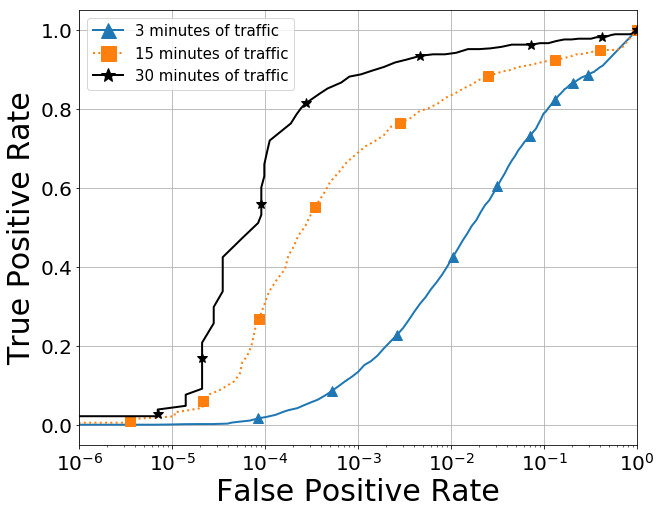

In [11]:
legend = []
styles = ['-^', ':s', '-o', '-*']
# colors = ['g','', 'b', 'k']
for m in range(len(minutes) - 1):
    plt.plot(fp_event[m], tp_event[m], styles[m], markevery = 10, markersize=10, linewidth = 2)
    legend.append('%d minutes of traffic'%(minutes[m]/60))
plt.plot(fp_event[-1], tp_event[-1], styles[-1], markevery = 10, markersize=10, linewidth = 2, color = 'k')
legend.append('%d minutes of traffic'%(minutes[-1]/60))
plt.legend(legend, loc='best', fontsize = 15, markerscale = 1.5)
# plt.xlim(7e-4,1e-1)
plt.xlabel('False Positive Rate', fontsize = 30)
plt.ylabel('True Positive Rate', fontsize = 30)
plt.xlim(10e-7, 10e-1)
plt.xscale('log')

# plt.xlim(-0.001, 0.01)

plt.grid()
plt.savefig('roc-shape-log.pdf', format = 'pdf', dpi = 1000)
plt.show()

In [14]:
rates = (fp_event, tp_event)
with open('shape-based-rates-BarLength-10.pickle', 'wb') as f:
    pickle.dump(rates, f)